In [65]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as ndi
import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm
from tensorflow.keras.layers import Lambda

from utils import *
from help import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Check devices
print("Available devices:", tf.config.list_physical_devices())

def get_pig_model(k1,k2):
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_"+str(k1)+"_"+str(k2), 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    # latest_weight = max(glob.glob(os.path.join("models_gmm_new_18_t1_injury_6_6", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    # latest_weight = max(glob.glob(os.path.join("models_gmm_new_7_t1_6_6", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    # latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_128", 'weights_*.h5')), key=os.path.getctime, default=None)
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6", 'weights_*.h5')), key=os.path.getctime, default=None)
    
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_hmrf_model(k1,k2):
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_hmrf_"+str(k1)+"_"+str(k2), 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_original(k1,k2):
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_"+str(k1)+"_"+str(k2)+"_orig", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_128_original():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_128_orig", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_96_full():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,7]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_FULL_6_6_96", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_atlas():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,251]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_atlas_6_6", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_atlas_new():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,103]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_atlas_6_6_new", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model
    
def get_pig_model_96():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,3]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_6_6_96", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_hmrf_model_128():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_hmrf_6_6_128", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_128():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_128", 'weights_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model
    
def get_pig_model_binary_96():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_96", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_binary_128():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_128", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model
    
def get_pig_model_atlas_new():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,103]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_atlas_6_6_new", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [66]:
k1=6
k2=6
validation_folder_path = "/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask"
validation_folder_path="results_doug"
validation_folder_path = "/cbica/home/dadashkj/OASIS_OAS1_0001_MR1"
# validation_folder_path="/cbica/home/dadashkj/synthstrip_data_v1.5"


subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
combined_model = get_pig_model(k1,k2)
pig_model = get_pig_model(k1,k2)
# pig_model = get_pig_hmrf_model(k1,k2)
# combined_model = get_pig_model_original(k1,k2)


# combined_model_128 = get_pig_model_128()


atlas=False
# combined_model_seg = get_pig_model()
# num_forground_classes=102 # 250
dial_param = 3 if atlas else 2

model is loading
models_gmm_6_6/weights_epoch_740.h5
model is loading
models_gmm_6_6/weights_epoch_740.h5


model is loading
models_gmm_6_6/weights_epoch_740.h5
model is loading
models_gmm_6_6_128/weights_2025-08-30_06-56.h5
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_t2_269
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/fsm_t1_46th
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_dwi_137
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/qin_t2_34
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/asl_t1_112
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_dwi_013
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/fsm_t1_67lq
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/cim_ct_0011
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/cim_ct_0017
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_mra_012
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/fsm_t1_85fp
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_t2_553
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/qin

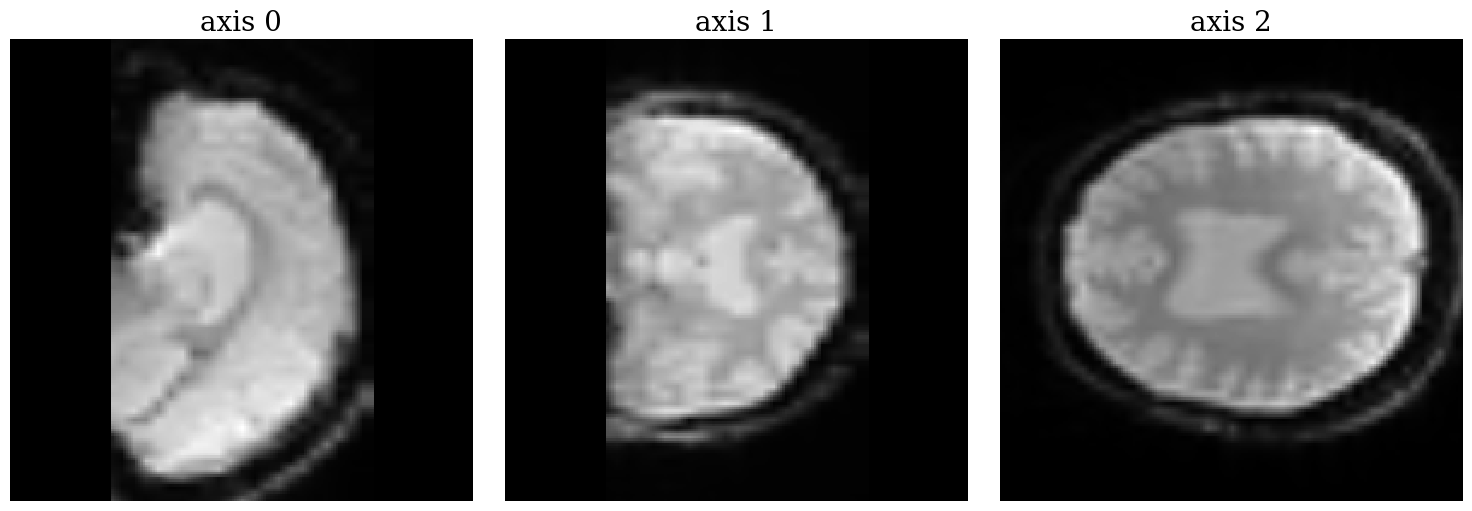

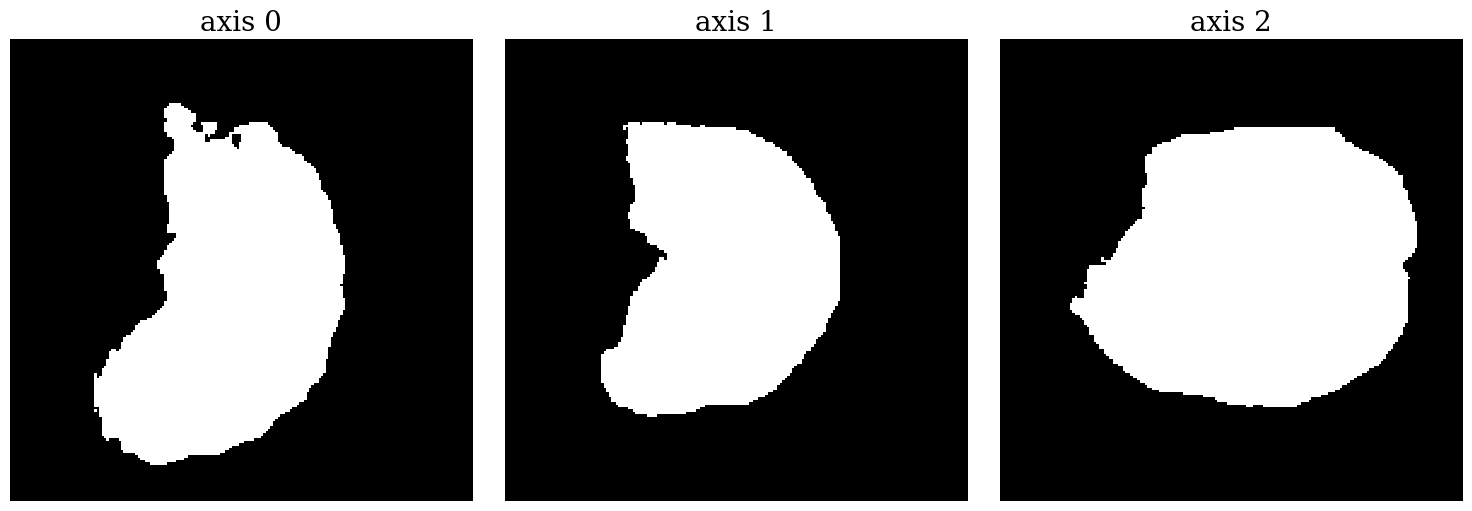

Dice coefficient for asl_epi_101: 0.1379
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/fsm_pd_79bf
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_mra_136
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_mra_527
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/asl_epi_112
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_t1_270
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_mra_521
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/qin_t2_28
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_t2_401
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/asl_epi_121
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_pd_275
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/cim_ct_0006
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/fsm_pd_91zs
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/qin_t2_48
@@@@@@@@@@@@@@ /cbica/home/dadashkj/synthstrip_data_v1.5/ixi_pd_231
@

In [81]:
import os
import numpy as np
import surfa as sf
import neurite as ne
from scipy import ndimage
from sklearn.metrics import jaccard_score
from utils import find_bounding_box, find_random_bounding_box, apply_gaussian_smoothing, extract_cube
import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage import zoom


import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

from scipy.ndimage import binary_dilation, binary_erosion
from sklearn.cluster import KMeans
import numpy as np

from scipy.ndimage import binary_erosion, binary_dilation, label
import numpy as np

from sklearn.decomposition import PCA

import numpy as np
from sklearn.decomposition import PCA
from scipy.ndimage import binary_dilation
import numpy as np
from scipy.ndimage import label

from scipy.ndimage import binary_erosion, binary_dilation, label
from scipy.ndimage import binary_erosion, binary_dilation
from sklearn.cluster import KMeans
import numpy as np

# Define a 3D structuring element (e.g., 3x3x3 cube)
structure = np.ones((3, 3, 3), dtype=bool)
resize_to_1=True

results_folder = "results_doug"
validation_folder_path = "/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask"
validation_folder_path = results_folder


subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
random.shuffle(subfolders)


combined_model = get_pig_model(k1,k2)
combined_model_128 = get_pig_model_128()


def majority_vote_binary(masks):
    """
    Combine a list of binary 3D masks into a single majority-voted binary mask.
    
    Parameters:
        masks (List[np.ndarray]): List of 3D numpy arrays (binary masks of shape (Z, Y, X))
    
    Returns:
        np.ndarray: 3D binary mask where each voxel is 1 if majority of masks had 1
    """
    masks_stack = np.stack(masks, axis=0)  # shape: (N, Z, Y, X)
    vote_sum = np.sum(masks_stack, axis=0)
    majority_threshold = len(masks) // 2 + 1  # majority means > N/2
    return (vote_sum >= majority_threshold).astype(np.uint8)
    

def fill_holes_per_class(mask, labels=None):
    filled_mask = np.zeros_like(mask)
    if labels is None:
        labels = np.unique(mask)
        labels = labels[labels != 0]  # skip background

    for label in labels:
        class_mask = (mask == label)
        filled_class = ndi.binary_fill_holes(class_mask)
        filled_mask[filled_class] = label

    return filled_mask

from scipy.ndimage import binary_dilation, binary_erosion

def fill_holes_by_dilate_erode(mask, iterations=2):
    filled_mask = np.zeros_like(mask)
    labels = np.unique(mask)
    labels = labels[labels != 0]  # Skip background

    for label in labels:
        binary = (mask == label)
        # Dilate first to close small holes
        dilated = binary_dilation(binary, iterations=iterations)
        # Erode to restore the shape
        cleaned = binary_erosion(dilated, iterations=iterations)
        filled_mask[cleaned] = label

    return filled_mask



import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

# def kmeans_merge_fg_and_prune(img, fg_mask, n_bg_clusters=5):
import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation
from scipy.ndimage import gaussian_filter
import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

import numpy as np
from scipy.ndimage import gaussian_filter, binary_dilation
from sklearn.mixture import GaussianMixture



def trim_mask(pred_mask, mask_dtype=np.uint8, proximity=2, remove_top_n=1):
    """
    Keeps the dominant class and nearby-attached small classes (within `proximity` voxels),
    but excludes the top-N largest non-dominant labels.

    Parameters:
        pred_mask (np.ndarray): labeled input mask
        mask_dtype (np.dtype): output data type (e.g., np.uint8)
        proximity (int): voxel distance to include nearby labels
        remove_top_n (int): number of largest non-dominant labels to exclude

    Returns:
        np.ndarray: final mask with original labels preserved
    """
    flat = pred_mask.ravel()
    labels, counts = np.unique(flat[flat > 0], return_counts=True)
    if len(counts) == 0:
        return np.zeros_like(pred_mask, dtype=mask_dtype)

    dominant_label = labels[np.argmax(counts)]
    dominant_mask = (pred_mask == dominant_label)
    expanded = binary_dilation(dominant_mask, iterations=proximity)

    # Sizes of all other labels
    label_sizes = {label: np.sum(pred_mask == label) for label in labels if label != dominant_label}
    sorted_labels = sorted(label_sizes.items(), key=lambda x: x[1], reverse=True)
    excluded_labels = set([lbl for lbl, _ in sorted_labels[:remove_top_n]])

    # Initialize final mask with the dominant region
    final_mask = np.zeros_like(pred_mask, dtype=mask_dtype)
    final_mask[dominant_mask] = dominant_label

    # Include small nearby-attached labels
    for label in labels:
        if label == dominant_label or label in excluded_labels:
            continue
        label_mask = (pred_mask == label)
        if np.any(label_mask & expanded):
            final_mask[label_mask] = label

    print("Dominant label:", dominant_label)
    print("Excluded labels (top {}):".format(remove_top_n), excluded_labels)
    print("Labels in final mask:", np.unique(final_mask))

    return final_mask

import numpy as np
from sklearn.decomposition import PCA

import numpy as np
from scipy.ndimage import binary_dilation



import numpy as np
from scipy.ndimage import label

def extract_labeled_largest_component(labeled_mask):
    """
    Returns a labeled mask where only the region under the largest connected component
    (from the binarized version) is preserved. All other areas are set to 0.

    Parameters:
        labeled_mask (np.ndarray): input mask with integer class labels

    Returns:
        np.ndarray: same shape as input, only largest binary component retained
                    with original labels
    """
    binary_mask = (labeled_mask > 0)

    # Step 2: Label connected components
    connected, num = label(binary_mask)
    if num == 0:
        return np.zeros_like(labeled_mask)

    # Step 3: Find largest component
    sizes = np.bincount(connected.ravel())
    sizes[0] = 0  # background
    largest_label = np.argmax(sizes)
    largest_region = (connected == largest_label)

    # Step 4: Mask original labels using that region
    result = np.where(largest_region, labeled_mask, 0)

    return result

from scipy.ndimage import binary_erosion, distance_transform_edt
import numpy as np
from scipy.ndimage import binary_erosion, distance_transform_edt

def prune_mask_by_distance_from_core(mask1, mask2, distance_thresh=10, erosion_iter=2):
    """
    Removes distant voxels in mask1 that are farther than `distance_thresh`
    from the eroded core of mask2.

    Parameters:
        mask1 (np.ndarray): binary mask to prune
        mask2 (np.ndarray): reference mask whose core is trusted
        distance_thresh (int): distance threshold in voxels
        erosion_iter (int): erosion depth to define core from mask2

    Returns:
        pruned_mask (np.ndarray): mask1 cleaned based on distance to core of mask2
    """
    # Step 1: Erode mask2 to get core
    core = binary_erosion(mask2, iterations=erosion_iter)

    # Step 2: Compute distance from core
    distance_from_core = distance_transform_edt(~core)

    # Step 3: Remove mask1 voxels that are too far from core
    pruned_mask = (mask1 > 0) & (distance_from_core <= distance_thresh)
    
    return pruned_mask.astype(np.uint8)

import numpy as np
from scipy.ndimage import center_of_mass, distance_transform_edt

import numpy as np
from scipy.ndimage import binary_dilation

import numpy as np
from scipy.ndimage import binary_dilation, label, sum as ndi_sum

from scipy.ndimage import binary_dilation, label, distance_transform_edt, sum as ndi_sum


def combine_mask_with_dilated_label(pred_192_2, initial_prediction, target_label=93, dilation_iters=50):
    """
    Combines pred_192_2 and initial_prediction into a binary mask.
    Uses binarized pred_192_2 in the largest dilated region around label==target_label,
    and initial_prediction elsewhere.

    Parameters:
        pred_192_2: np.ndarray, multi-class segmentation
        initial_prediction: np.ndarray, binary mask
        target_label: int, label to use as trust anchor (default: 93)
        dilation_iters: int, how many voxels to dilate label region

    Returns:
        final_binary_mask: np.ndarray, 0 for background, 2 for foreground
    """

    # Step 1: Find label==target_label region
    label_region = (pred_192_2 == target_label)
    if not np.any(label_region):
        print(f"Warning: Label {target_label} not found. Using initial_prediction everywhere.")
        return (initial_prediction > 0).astype(np.int32) * 2

    # Step 2: Dilate label region
    dilated_region = binary_dilation(label_region, iterations=dilation_iters)

    # Step 3: Extract largest connected component from dilated region
    labeled_components, num_components = label(dilated_region)
    if num_components == 0:
        print(f"Warning: No connected components after dilation. Using initial_prediction everywhere.")
        return (initial_prediction > 0).astype(np.int32) * 2

    component_sizes = ndi_sum(dilated_region, labeled_components, index=np.arange(1, num_components + 1))
    largest_component_label = np.argmax(component_sizes) + 1  # labels start from 1
    trusted_region = (labeled_components == largest_component_label)

    # Step 4: Binarize pred_192_2 → 0 or 2
    mask_binary = (pred_192_2 > 0).astype(np.int32) * 2

    # Step 5: Binarize initial_prediction → 0 or 2
    init_binary = (initial_prediction > 0).astype(np.int32) * 2

    # Step 6: Merge based on trusted region
    final_mask = np.where(trusted_region, mask_binary, init_binary)

    return final_mask

from scipy.ndimage import binary_erosion, label, sum as ndi_sum

from scipy.ndimage import binary_erosion, gaussian_filter, label
from scipy.ndimage import sum as ndi_sum

from scipy.ndimage import binary_erosion, gaussian_filter, label
from scipy.ndimage import sum as ndi_sum
import numpy as np

def clean_mask(image, mask, border=5, thresh=0.1, sigma=2.8):
    m = (mask > 0)
    struct = np.ones((3, 3, 3), dtype=bool)  # for 3D erosion

    print("##########",m.shape)
    eroded = binary_erosion(m, structure=struct, iterations=border)
    m[~eroded & (image < thresh)] = 0
    lbl, n = label(m)
    if n == 0: return np.zeros_like(mask)
    m = (lbl == 1 + np.argmax(ndi_sum(m, lbl, index=np.arange(1, n + 1))))
    return (gaussian_filter(m.astype(float), sigma) > 0.5).astype(mask.dtype)



def refine_prediction2(crop_img, image, mask, mask2, model, folder,
                       orig_voxsize, suffix="",
                       new_image_size=(192, 192, 192), margin=0, cube_size=128):
    """
    Returns the final binary prediction mask (no file saving).
    """
    prediction_one_hot = model.predict(crop_img[None, ...], verbose=0)
    initial_prediction = np.argmax(prediction_one_hot, axis=-1)[0]

    labeled, num_components = ndi.label(initial_prediction > 0)
    if num_components == 0:
        return np.zeros_like(initial_prediction)

    largest_mask = labeled == np.argmax(ndi.sum(initial_prediction > 0, labeled, range(num_components + 1)))
    initial_prediction = ndi.binary_fill_holes(largest_mask)
    initial_prediction = (initial_prediction > 0).astype(np.int32)

    final_pred = (initial_prediction > 0).astype(np.uint8)
    return final_pred
    


    # # nib.save(nib.Nifti1Image(sf.Volume(pred_192.astype(np.int32)).resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join(folder_path, 'third_prediction.nii.gz'))
    # return pred_192_2

# Store Dice coefficients
dice_scores = []

new_voxsize = [0.5, 0.5, 0.5]
# new_voxsize = [0.8, 0.8, 0.8]
import numpy as np
for folder in subfolders:
    folder_path = os.path.join(validation_folder_path, folder)
    folder_name = os.path.basename(folder_path)
    folder_path_2 = os.path.join(results_folder, folder)
    
    # filename = os.path.join(folder_path, f"{folder_name}_T1.nii.gz")
    # mask_filename = os.path.join(folder_path, f"{folder_name}_T1_mask.nii.gz")
    print("@@@@@@@@@@@@@@",folder_path)
    filename = os.path.join(folder_path, f"image.nii.gz")
    mask_filename = os.path.join(folder_path, f"mask.nii.gz")


    if "asl_epi_101" not in filename:
        continue
    
    # if "2017-2_post" not in filename:
    #     continue
    # if "JAW-106_6month" in filename:
    #     print("NO MASK FOUND")
    #     continue
        
    print(filename)
    


    # Skip if no input file
    if not os.path.isfile(filename):
        continue
        
    # Load and process image
    filename = os.path.join(folder_path_2, 'image.nii.gz')
    image = sf.load_volume(filename)
    if resize_to_1:
        image =image.resize(1)
    orig_voxsize = image.geom.voxsize
    # crop_img = image.resize(new_voxsize, method="linear").reshape([192, 192, 192, 1])
    crop_img = image.reshape([192, 192, 192, 1])
    orig_shape = image.shape
    # orig_voxsize=crop_img.geom.voxsize

    # Binarize the mask
    

        # Load mask
    if not os.path.isfile(mask_filename):
        mask = sf.Volume(np.ones((192, 192, 192)))
    else:
        
        mask2 = sf.load_volume(mask_filename)
        mask = sf.load_volume(mask_filename)
        if resize_to_1:
            mask=mask.resize(1)
            mask2=mask2.resize(1)

        mask2=mask2.reshape(orig_shape)#resize(new_voxsize, method="linear")
        affine = np.array(image.geom.vox2world)
        print("mask shape",mask2.shape,"image shape",image.shape)
        nib.save(nib.Nifti1Image(mask2.astype(np.int32), affine), os.path.join(folder_path_2, 'mask.nii.gz'))
        mask2 = mask2.reshape([192, 192, 192, 1])

        mask_filename = os.path.join(folder_path_2, f"mask_drew.nii.gz")
        
        # mask = mask.reshape(orig_shape)
        mask = mask.reshape([192, 192, 192, 1])
        
    mask.data[mask.data != 0] = 1
    mask2.data[mask2.data != 0] = 1

    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    
    # prediction_seg = refine_prediction1(crop_img, image, mask, mask2, combined_model,combined_model_128,
    #                             combined_model_hmrf_128,
    #                             combined_model_96, folder, new_image_size=(192, 192, 192))

    prediction = refine_prediction2(crop_img, image, mask, mask2, pig_model, folder,orig_voxsize, new_image_size=(192, 192, 192))

    ne.plot.volume3D(crop_img)
    ne.plot.volume3D(prediction)
    # Compute Dice coefficient
    mask_flat = mask.data.flatten()
    prediction_flat = prediction.flatten()>0
    dice_score = 2 * np.sum(mask_flat * prediction_flat) / (np.sum(mask_flat) + np.sum(prediction_flat))
    if np.sum(mask.data)<1000:
        continue
    
    prediction = sf.Volume(prediction).reshape(orig_shape).data
    nib.save(nib.Nifti1Image(prediction.astype(np.int32), affine), os.path.join(folder_path_2, 'prediction.nii.gz'))
    
    dice_scores.append(dice_score)

    print(f"Dice coefficient for {folder_name}: {dice_score:.4f}")
    # break

# Overall Dice coefficient and visualization
overall_dice = np.mean(dice_scores)
print(f"Overall Dice coefficient: {overall_dice:.4f}")



In [75]:
orig_shape

(64, 64, 22)

In [79]:
crop_img.shape

(192, 192, 192)

In [23]:
image.geom.voxsize

array([3.4375, 3.4375, 5.    ])

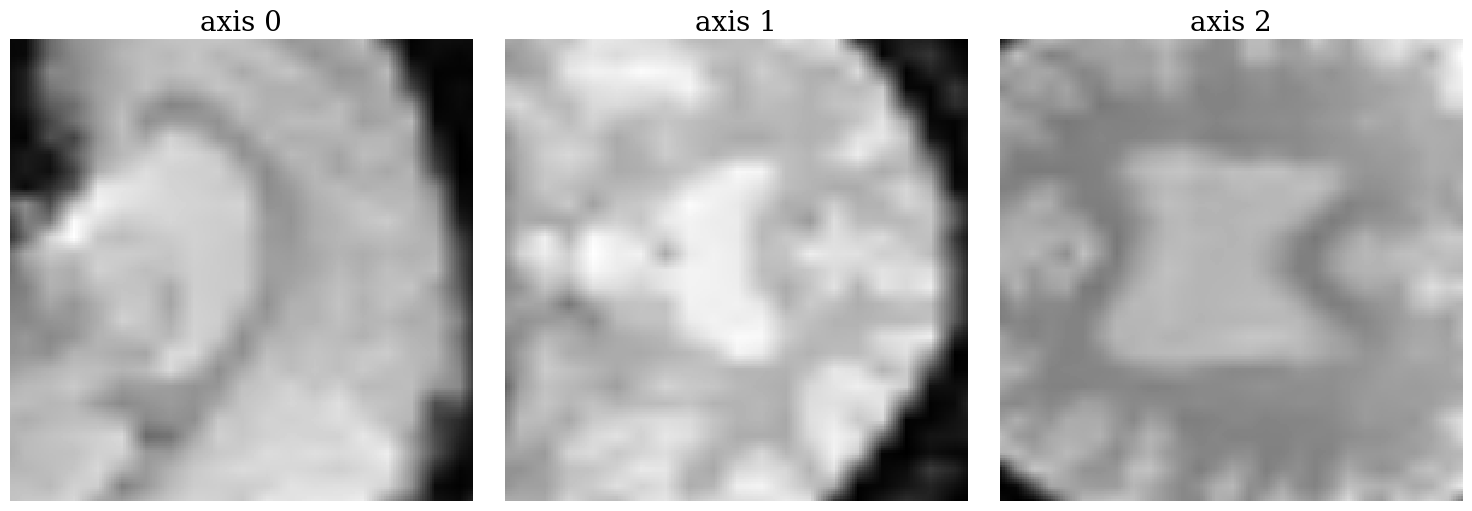

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [27]:
a=image.resize(0.5).reshape((192,)*3)
ne.plot.volume3D(a)

In [49]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from medpy.metric.binary import dc
from tqdm import tqdm
from pathlib import Path

# ----------- Paths -----------
base_dir = Path("results")
output_csv = "segmentation_evaluation.csv"

# ----------- Utility Functions -----------
def load_nifti(file_path):
    return nib.load(str(file_path)).get_fdata()

def binarize(volume):
    return (volume > 0).astype(np.uint8)

def compute_dice(gt, pred):
    gt_bin, pred_bin = binarize(gt), binarize(pred)
    if gt_bin.sum() == 0 or pred_bin.sum() == 0:
        return 0.0
    return dc(pred_bin, gt_bin)

# ----------- Define Prediction Variants -----------
def get_all_baselines():
    # common_models = [
    #     "orig",
    #     "universeg",
    #     "bet",
    #     "third_prediction_hmrf",
    #     "third_prediction_gmm",         # dual-channel tested on T1
    #     "third_prediction_gmm-t2",      # dual-channel tested on T2
    #     "t1-third_prediction_gmm",      # T1-only model tested on T1
    #     "t1-third_prediction_gmm-t2",   # T1-only model tested on T2
    #     "t2-third_prediction_gmm",      # T2-only model tested on T1
    #     "t2-third_prediction_gmm-t2",   # T2-only model tested on T2
    # ]
    common_models = [
        "orig",
        "universeg",
        "bet",
        "third_prediction_hmrf",
        "third_prediction_gmm",         # dual-channel tested on T1
        "third_prediction_gmm-t2",      # dual-channel tested on T2
        "t1-18_t1",      # T1-only model tested on T1
        "t1-18_t2",   # T1-only model tested on T2
        "t2-18_t1",      # T2-only model tested on T1
        "t2-18_t2",   # T2-only model tested on T2
    ]
    unique_models = [f"{i}_unique_training" for i in range(1, 8)]
    normal_models = [f"{i}_training" for i in range(1, 12)]
    return unique_models + normal_models + common_models

# ----------- Main Evaluation Loop -----------
results = []
subjects = [p for p in base_dir.iterdir() if p.is_dir()]

for subj_path in tqdm(subjects, desc="Evaluating"):
    subject = subj_path.name
    try:
        gt1 = load_nifti(subj_path / "mask_drew.nii.gz")  # Expert 1
        gt2 = load_nifti(subj_path / "mask.nii.gz")       # Expert 2
        baselines = get_all_baselines()

        stats = {
            "Subject": subject,
            "Dice_Expert1_vs_Expert2": compute_dice(gt1, gt2),
        }

        for baseline in baselines:
            pred_file = subj_path / f"{baseline}.nii"
            if not pred_file.exists():
                pred_file = pred_file.with_suffix(".nii.gz")
            if pred_file.exists():
                try:
                    pred = load_nifti(pred_file)
                    stats[f"Dice_{baseline}_vs_Expert1"] = compute_dice(gt1, pred)
                    stats[f"Dice_{baseline}_vs_Expert2"] = compute_dice(gt2, pred)
                except Exception as eval_err:
                    print(f"⚠️ Dice error for {baseline} in {subject}: {eval_err}")
            else:
                print(f"❌ Missing prediction: {baseline} for {subject}")

        results.append(stats)

    except Exception as e:
        print(f"🚫 Skipping {subject} due to error: {e}")

# ----------- Save Output -----------
df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f"✅ Saved: {output_csv}")


Evaluating:  20%|███████████████████▊                                                                               | 3/15 [00:35<02:15, 11.32s/it]

🚫 Skipping .ipynb_checkpoints due to error: No such file or no access: 'results/.ipynb_checkpoints/mask_drew.nii.gz'


Evaluating:  47%|██████████████████████████████████████████████▏                                                    | 7/15 [01:13<01:25, 10.66s/it]

❌ Missing prediction: third_prediction_gmm-t2 for JAW-076_pre
❌ Missing prediction: t1-18_t2 for JAW-076_pre


Evaluating:  53%|████████████████████████████████████████████████████▊                                              | 8/15 [01:25<01:16, 10.93s/it]

❌ Missing prediction: t2-18_t2 for JAW-076_pre


Evaluating:  80%|██████████████████████████████████████████████████████████████████████████████▍                   | 12/15 [02:13<00:36, 12.09s/it]

🚫 Skipping test due to error: No such file or no access: 'results/test/mask_drew.nii.gz'
❌ Missing prediction: t1-18_t2 for JAW-096_post


Evaluating:  93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 14/15 [02:26<00:09,  9.48s/it]

❌ Missing prediction: t2-18_t2 for JAW-096_post


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:39<00:00, 10.63s/it]

✅ Saved: segmentation_evaluation.csv


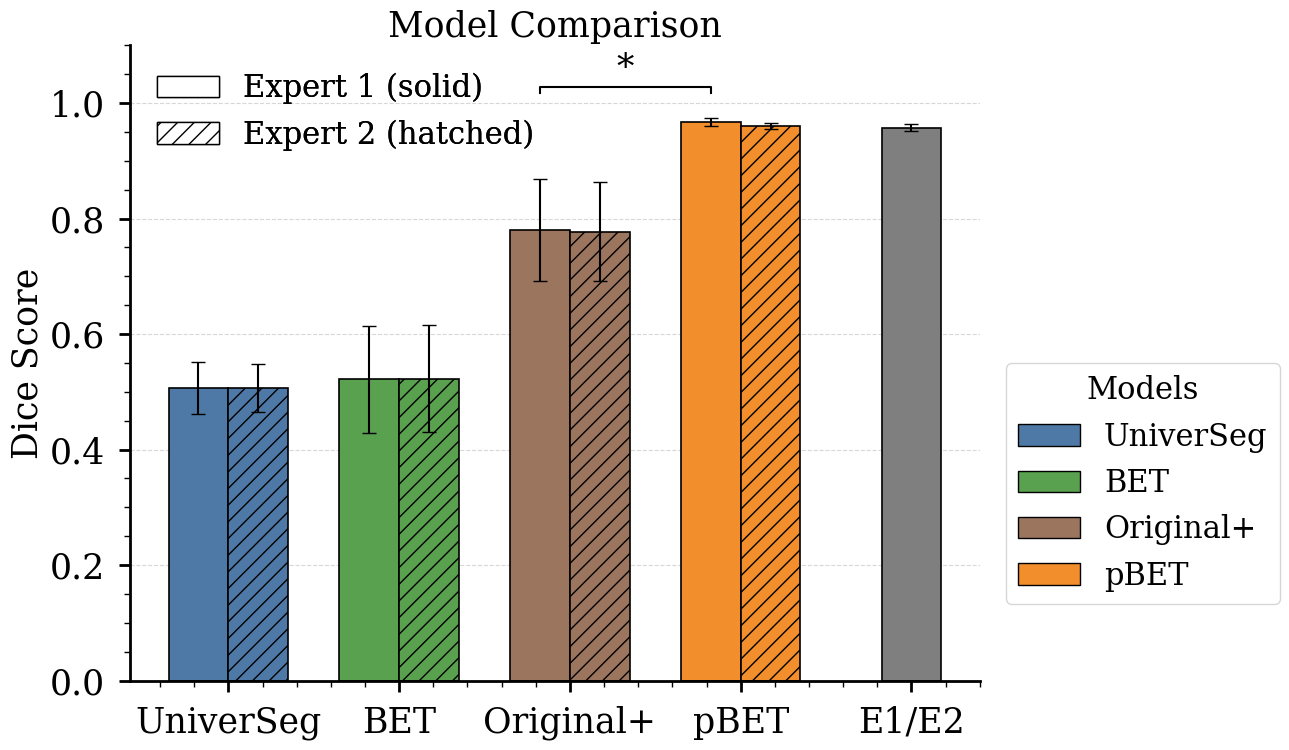

In [26]:
#!/usr/bin/env python3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel
from matplotlib.patches import Patch

# ================== GLOBAL PLOT STYLES (Nature-like) ==================
plt.rcParams.update({
    "font.family": "serif",
    "axes.linewidth": 2.0,
    "xtick.labelsize": 25,
    "ytick.labelsize": 25,
    "axes.titlesize": 25,
    "legend.fontsize": 22,
    "legend.title_fontsize": 22,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "text.color": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.edgecolor": "black",
})

# Load CSV
df = pd.read_csv("segmentation_evaluation.csv")

# -------------------- FIGURE 1: BAR PLOT --------------------
fig_bar, ax_bar = plt.subplots(figsize=(10, 8))

# Axis cosmetics
ax_bar.spines['left'].set_linewidth(plt.rcParams["axes.linewidth"])
ax_bar.spines['bottom'].set_linewidth(plt.rcParams["axes.linewidth"])
ax_bar.minorticks_on()
ax_bar.yaxis.grid(True, which="major", linestyle="--", linewidth=0.8, alpha=0.5)
ax_bar.xaxis.grid(False)
ax_bar.set_axisbelow(True)
ax_bar.tick_params(axis="both", which="major", direction="out", length=8, width=2.0,
                   top=False, right=False, pad=10)
ax_bar.tick_params(axis="both", which="minor", direction="out", length=4, width=1.0,
                   top=False, right=False)

# --- Methods & labels ---
methods = {
    "universeg": "UniverSeg",
    "bet": "BET",
    "orig": "Original+",
    "third_prediction_gmm": "pBET"   # ✅ now one line
}

labels, mean_e1, std_e1, mean_e2, std_e2, is_shared_bar = [], [], [], [], [], []

for method, label in methods.items():
    col_e1 = f"Dice_{method}_vs_Expert1"
    col_e2 = f"Dice_{method}_vs_Expert2"
    if col_e1 in df.columns and col_e2 in df.columns:
        mean_e1.append(df[col_e1].mean())
        std_e1.append(df[col_e1].std())
        mean_e2.append(df[col_e2].mean())
        std_e2.append(df[col_e2].std())
        labels.append(label)
        is_shared_bar.append(False)

# Add inter-rater E1/E2 if present (single/shared bar)
if "Dice_Expert1_vs_Expert2" in df.columns:
    labels.append("E1/E2")
    mean_e1.append(df["Dice_Expert1_vs_Expert2"].mean())
    std_e1.append(df["Dice_Expert1_vs_Expert2"].std())
    mean_e2.append(np.nan)
    std_e2.append(np.nan)
    is_shared_bar.append(True)

# Indices for significance bracket and ordering
gmm_idx = labels.index("pBET")
orig_idx = labels.index("Original+")
e1e2_idx = labels.index("E1/E2")

custom_order = [i for i in range(len(labels)) if i not in [gmm_idx, e1e2_idx]]
custom_order += [gmm_idx, e1e2_idx]

# X positions and width
x = np.arange(len(labels))
bar_width = 0.35

# ====== Color palette per MODEL ======
model_colors = {
    "UniverSeg":  "#4E79A7",  # blue
    "BET":        "#59A14F",  # green
    "Original+":  "#9C755F",  # brown
    "pBET":  "#F28E2B",  # orange
}
interrater_color = "#7F7F7F"

# Collect handles for the outside (model) legend
model_handles = {}

# Plot bars
for i in custom_order:
    if is_shared_bar[i]:
        m = mean_e1[i]; s = std_e1[i]
        err = np.minimum(s if np.isfinite(s) else 0, 1.0 - (m if np.isfinite(m) else 0))
        ax_bar.bar(
            x[i], m,
            yerr=[[err], [err]] if np.isfinite(err) else None,
            width=bar_width,
            color=interrater_color, edgecolor="black", linewidth=1.2, capsize=5,
            label="E1/E2" if i == custom_order[-1] else ""
        )
    else:
        model_label = labels[i]
        base_color = model_colors.get(model_label, "#888888")

        # Expert 1 (solid)
        m1 = mean_e1[i]; s1 = std_e1[i]
        err1 = np.minimum(s1 if np.isfinite(s1) else 0, 1.0 - (m1 if np.isfinite(m1) else 0))
        ax_bar.bar(
            x[i] - bar_width / 2, m1,
            width=bar_width,
            yerr=[[err1], [err1]] if np.isfinite(err1) else None,
            color=base_color, edgecolor="black", linewidth=1.2, capsize=5
        )

        # Expert 2 (hatched)
        m2 = mean_e2[i]; s2 = std_e2[i]
        err2 = np.minimum(s2 if np.isfinite(s2) else 0, 1.0 - (m2 if np.isfinite(m2) else 0))
        ax_bar.bar(
            x[i] + bar_width / 2, m2,
            width=bar_width,
            yerr=[[err2], [err2]] if np.isfinite(err2) else None,
            color=base_color, edgecolor="black", linewidth=1.2, hatch="//", capsize=5
        )

        # Save for model legend
        if model_label not in model_handles:
            model_handles[model_label] = Patch(facecolor=base_color, edgecolor="black", label=model_label)

# Labels & axes
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(labels, fontsize=25)
ax_bar.set_ylabel("Dice Score", fontsize=25)
ax_bar.set_title("Model Comparison", fontsize=25)
ax_bar.set_ylim(0, 1.1)

# --- Significance line ---
x1 = x[orig_idx] - bar_width / 2
x2 = x[gmm_idx] - bar_width / 2
m1 = mean_e1[orig_idx] if np.isfinite(mean_e1[orig_idx]) else np.nan
m2 = mean_e1[gmm_idx] if np.isfinite(mean_e1[gmm_idx]) else np.nan
y_max = np.nanmax([m1, m2]) + 0.05 if np.all(np.isfinite([m1, m2])) else 0.9

ax_bar.plot([x1, x1, x2, x2], [y_max, y_max + 0.01, y_max + 0.01, y_max],
            lw=1.5, color="black")
ax_bar.text((x1 + x2) / 2, y_max + 0.025, "*", ha="center", fontsize=25)

# ================== LEGENDS ==================
# 1) Outside bottom-right legend for MODELS
handles_models = [model_handles[k] for k in labels if k in model_handles]
seen = set()
ordered_handles, ordered_labels = [], []
for h in handles_models:
    lbl = h.get_label()
    if lbl not in seen:
        seen.add(lbl)
        ordered_handles.append(h)
        ordered_labels.append(lbl)

fig_bar.legend(
    ordered_handles, ordered_labels,
    title="Models",
    loc="lower right",
    bbox_to_anchor=(1.3, 0.22),  # outside bottom-right
    frameon=True
)

# 2) Style key for Expert 1 vs Expert 2 (transparent background)
style_handles = [
    Patch(facecolor="#FFFFFF", edgecolor="black", label="Expert 1 (solid)"),
    Patch(facecolor="#FFFFFF", edgecolor="black", hatch="//", label="Expert 2 (hatched)")
]
leg2 = ax_bar.legend(handles=style_handles, loc="upper left", frameon=False)  # ✅ transparent
ax_bar.add_artist(leg2)

# Layout & save
fig_bar.tight_layout(rect=(0, 0.05, 1, 1))
fig_bar.savefig("figure_bar_only.png", dpi=300, bbox_inches="tight")
plt.show()


In [28]:
import tensorflow as tf; print(tf.__version__)

2.7.0


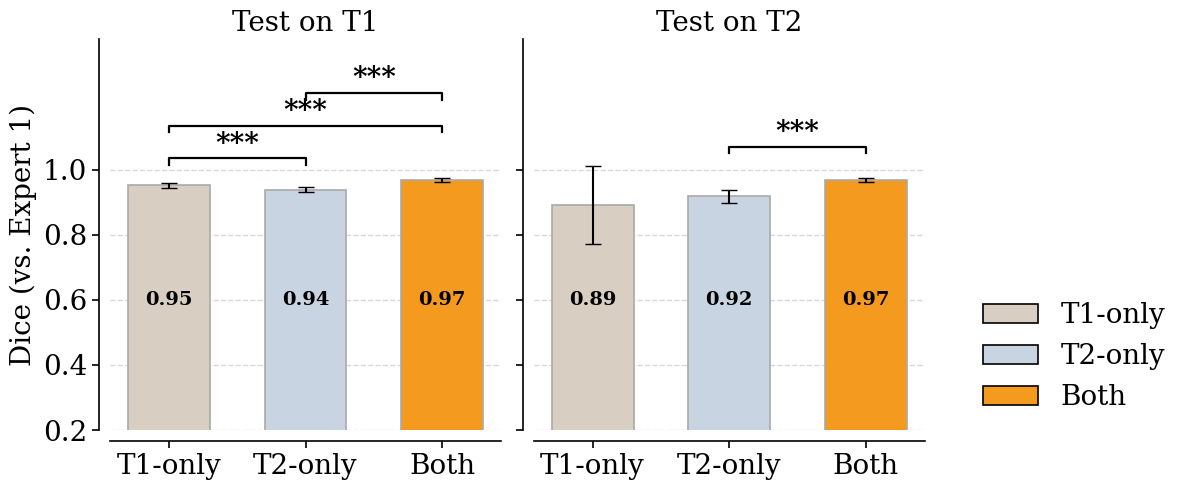

In [7]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from pathlib import Path

# --- Load results ---
csv_path = Path("segmentation_evaluation.csv")
df = pd.read_csv(csv_path)

# --- Column map (Expert 1 only) ---
COL = {
    ("T1-only", "T1"): "Dice_t1-18_t1_vs_Expert1",
    ("T1-only", "T2"): "Dice_t1-18_t2_vs_Expert1",
    ("T2-only", "T1"): "Dice_t2-18_t1_vs_Expert1",
    ("T2-only", "T2"): "Dice_t2-18_t2_vs_Expert1",
    ("Both",    "T1"): "Dice_third_prediction_gmm_vs_Expert1",
    ("Both",    "T2"): "Dice_third_prediction_gmm-t2_vs_Expert1",
}

TRAINS = ["T1-only", "T2-only", "Both"]
TESTS  = ["T1", "T2"]

# --- Style (all fonts = 20) ---
plt.rcParams.update({
    "font.family": "serif",
    "axes.linewidth": 1.2,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.titlesize": 20,
    "legend.fontsize": 20,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

colors_train = {
    "T1-only": "#D8CEC2",  # warm sand
    "T2-only": "#C9D4E3",  # light blue-gray
    "Both":    "#F39A1F",  # vivid orange
}


def p_to_stars(p):
    return "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 0.05 else None

def aligned_pairs(series_a, series_b):
    m = pd.concat([series_a, series_b], axis=1).dropna()
    if len(m) >= 2:
        return m.iloc[:,0].values, m.iloc[:,1].values
    return None, None

def add_sig_bracket(ax, x1, x2, y_top, label, h=0.02):
    if not label:
        return
    y = y_top + h
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], color="black", lw=1.6, zorder=5)
    ax.text((x1+x2)/2, y+h*1.1, label, ha="center", va="bottom", fontsize=20, weight="bold", zorder=6)

def clean_series(df, col):
    if col not in df.columns:
        return pd.Series(dtype=float)
    s = pd.to_numeric(df[col], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    return s[np.isfinite(s)]

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
width = 0.6
FIXED_LABEL_Y = 0.6  # <- all bar numbers align on this Y (data coords)

for ax, test in zip(axes, TESTS):
    means, stds, raws = [], [], []
    for tr in TRAINS:
        col = COL.get((tr, test))
        s = clean_series(df, col)
        raws.append(s)
        means.append(s.mean() if len(s) else np.nan)
        stds.append(s.std(ddof=1) if len(s) > 1 else 0.0)

    x = np.arange(len(TRAINS))
    bars = ax.bar(
        x, means, width=width,
        yerr=stds, capsize=6, ecolor="black",
        color=[colors_train[t] for t in TRAINS],
        edgecolor="darkgray", linewidth=1.2, zorder=2,
    )

    # --- Mean labels on a single horizontal line (font 20) ---
    for i, bar in enumerate(bars):
        m = means[i]
        if not np.isnan(m):
            ax.text(
                bar.get_x() + bar.get_width()/2,
                FIXED_LABEL_Y,
                f"{m:.2f}",
                ha="center", va="center",
                fontsize=14, color="black", weight="bold", zorder=6
            )

    # Cosmetics
    ax.set_title(f"Test on {test}", fontsize=20, pad=6)
    ax.set_xticks(x, TRAINS)
    ax.yaxis.grid(True, which="major", linestyle="--", linewidth=1.0, alpha=0.5)
    ax.xaxis.grid(False)
    ax.set_axisbelow(True)
    ax.set_ylim(0.20, 1.40)
    ax.set_yticks(np.arange(0.2, 1.01, 0.2))
    ax.spines['left'].set_position(('outward', 8))
    ax.spines['bottom'].set_position(('outward', 8))
    ax.tick_params(axis="both", which="both", direction="out", length=5, width=1.2, top=False, right=False)

    # Pairwise significance (ensure brackets above the number line)
    comps = [(0,1), (0,2), (1,2)]
    def safe_top(i):
        m, e = means[i], stds[i]
        m = 0 if np.isnan(m) else m
        e = 0 if not np.isfinite(e) else e
        top = m + e
        if len(raws[i]):
            top = max(top, np.nanmax(raws[i]))
        return top
    base_top = max(safe_top(0), safe_top(1), safe_top(2))

    bump = 0.1
    level = 0
    for (i, j) in comps:
        a, b = aligned_pairs(raws[i], raws[j])
        if a is None:
            continue
        _, pval = ttest_rel(a, b, nan_policy="omit")
        stars = p_to_stars(pval)
        if stars:
            # place above both the bar tops and the fixed number line
            y_base = max(base_top + 0.02, FIXED_LABEL_Y + 0.03)
            y_here = y_base + bump * level
            add_sig_bracket(ax, x[i], x[j], y_here, stars, h=0.02)
            level += 1

axes[0].set_ylabel("Dice (vs. Expert 1)", fontsize=20)

# Legend: nudge right so it doesn't overlap the right panel
handles = [plt.Rectangle((0,0),1,1, color=colors_train[t], ec="black", lw=1.2) for t in TRAINS]
labels  = TRAINS
axes[1].legend(
    handles, labels,
    loc="lower left",
    bbox_to_anchor=(1.12, 0.02),
    frameon=True, facecolor="white", framealpha=0.6, edgecolor="white",
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig("ttests_by_testmodality.png", dpi=300, bbox_inches="tight")
plt.show()


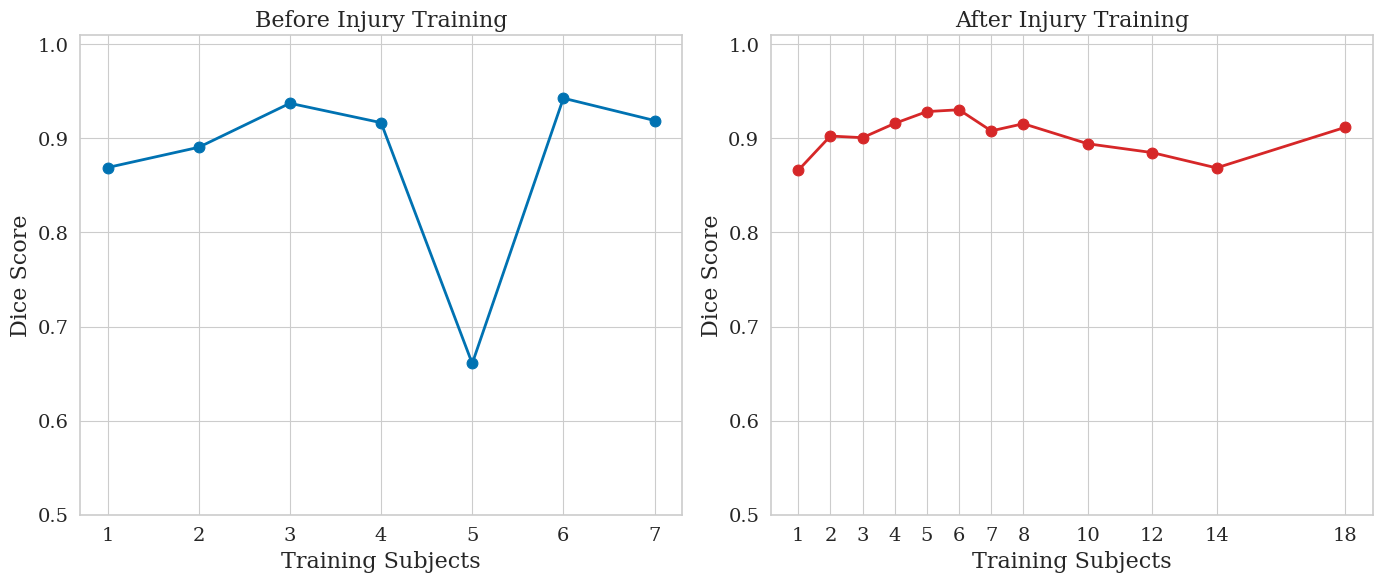

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re

def extract_clean_dice_scores(pattern):
    files = sorted(glob.glob(pattern), key=lambda x: int(re.findall(r'\d+', x)[-1]))
    all_scores = []
    for f in files:
        try:
            df_local = pd.read_csv(f)
            scores = df_local.values[-1]  # get last row
            # filter numeric values only
            numeric_scores = [float(v) for v in scores if isinstance(v, (int, float)) or (isinstance(v, str) and v.replace('.', '', 1).isdigit())]
            size = int(re.findall(r'\d+', f)[-1])
            for val in numeric_scores:
                all_scores.append((size, val))
        except Exception as e:
            print(f"Error reading {f}: {e}")
    return pd.DataFrame(all_scores, columns=["Training Size", "Dice"])

# Plotting section
sns.set(style="whitegrid", context="paper", font_scale=1.3)
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.linewidth"] = 1.2

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before Injury
before_df = extract_clean_dice_scores("dice_scores_t1_[1-7].csv")
ax = axes[0]
ax.tick_params(axis='both', labelsize=14)
grouped = before_df.groupby("Training Size")["Dice"]
x_vals = np.array(sorted(grouped.mean().index))
y_vals = grouped.mean().astype(float).values
y_err = grouped.std().astype(float).values

ax.plot(x_vals, y_vals, color="#0072B2", lw=2, label="Mean ± SD")
ax.fill_between(x_vals, y_vals - y_err, y_vals + y_err, color="#0072B2", alpha=0.2)
ax.scatter(x_vals, y_vals, color="#0072B2", s=60, zorder=3)
ax.set_xlabel("Training Subjects", fontsize=16)
ax.set_ylabel("Dice Score", fontsize=16)
ax.set_title("Before Injury Training", fontsize=16)
ax.set_ylim(0.5, 1.01)
ax.set_xticks(x_vals)

# After Injury
injury_df = extract_clean_dice_scores("dice_scores_t1_injury_*.csv")
ax = axes[1]
ax.tick_params(axis='both', labelsize=14)
grouped = injury_df.groupby("Training Size")["Dice"]
x_vals = np.array(sorted(grouped.mean().index))
y_vals = grouped.mean().astype(float).values
y_err = grouped.std().astype(float).values

ax.plot(x_vals, y_vals, color="#D62728", lw=2, label="Mean ± SD")
ax.fill_between(x_vals, y_vals - y_err, y_vals + y_err, color="#D62728", alpha=0.2)
ax.scatter(x_vals, y_vals, color="#D62728", s=60, zorder=3)
ax.set_xlabel("Training Subjects", fontsize=16)
ax.set_ylabel("Dice Score", fontsize=16)
ax.set_title("After Injury Training", fontsize=16)
ax.set_ylim(0.5, 1.01)
ax.set_xticks(x_vals)

plt.tight_layout()
plt.savefig("gmm_vs_before_injury.png", dpi=300)
plt.show()


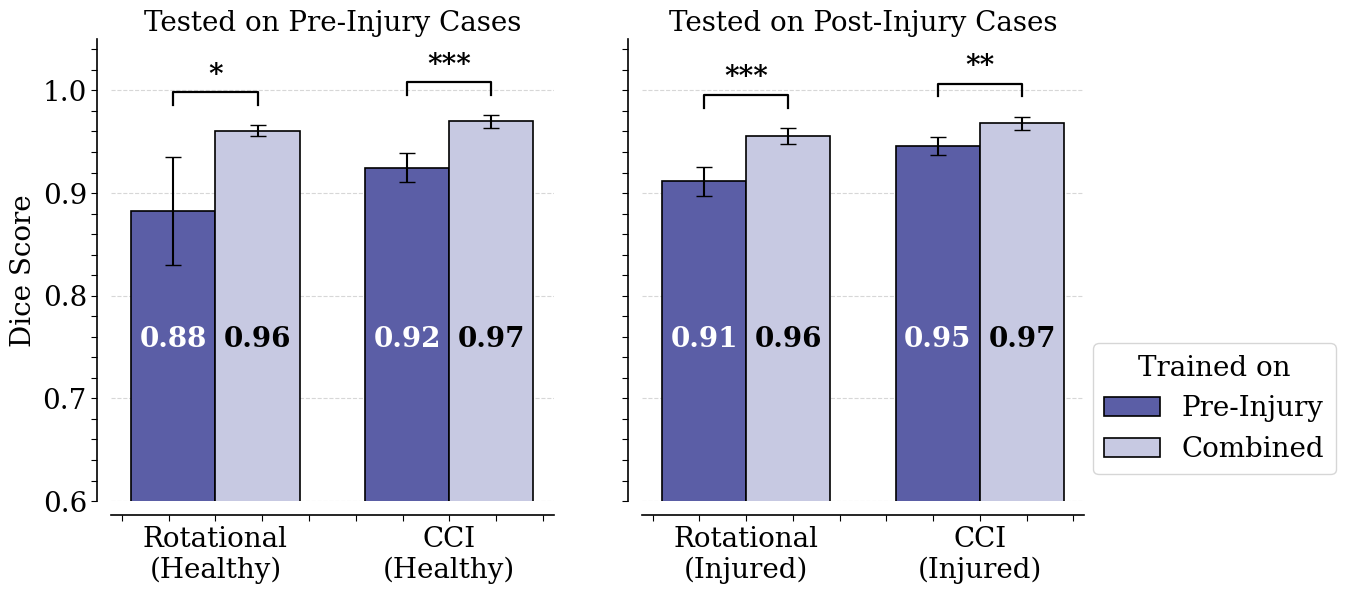

In [2]:
#!/usr/bin/env python3
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.colors as mcolors

# ================== CONFIG ==================
# Ns for Welch t-test fallback (when only means/SDs are present)
N_BY_GROUP = {
    ("Uninjured", "Rotational Injury Dataset\n(Healthy)"): 5,
    ("Both",      "Rotational Injury Dataset\n(Healthy)"): 5,
    ("Uninjured", "CCI injury dataset\n(Healthy)"): 5,
    ("Both",      "CCI injury dataset\n(Healthy)"): 5,
    ("Uninjured", "Rotational Injury Dataset\n(Injured)"): 5,
    ("Both",      "Rotational Injury Dataset\n(Injured)"): 5,
    ("Uninjured", "CCI injury dataset\n(Injured)"): 5,
    ("Both",      "CCI injury dataset\n(Injured)"): 8,
}

# ========= File mapping =========
# Rotational Injury Dataset -> Doug files
# CCI injury dataset        -> non-Doug files
file_mapping = {
    # Rotational Injury Dataset (Doug)
    ("Uninjured", "Rotational Injury Dataset\n(Healthy)"): "dice_scores_doug__7.csv",
    ("Both",      "Rotational Injury Dataset\n(Healthy)"): "dice_scores_doug__0.csv",
    ("Uninjured", "Rotational Injury Dataset\n(Injured)"): "dice_scores_doug_injury_7.csv",
    ("Both",      "Rotational Injury Dataset\n(Injured)"): "dice_scores_doug_injury_0.csv",

    # CCI injury dataset (non-Doug)
    ("Uninjured", "CCI injury dataset\n(Healthy)"): "dice_scores__7.csv",
    ("Both",      "CCI injury dataset\n(Healthy)"): "dice_scores_0.csv",
    ("Uninjured", "CCI injury dataset\n(Injured)"): "dice_scores_injury_7.csv",
    ("Both",      "CCI injury dataset\n(Injured)"): "dice_scores_injury_0.csv",
}

# PANELS (FIRST ROW ONLY)
panel_tests = {
    "Pre-Injury":  ["Rotational Injury Dataset\n(Healthy)", "CCI injury dataset\n(Healthy)"],
    "Post-Injury": ["Rotational Injury Dataset\n(Injured)", "CCI injury dataset\n(Injured)"],
}

train_labels   = ["Uninjured", "Both"]
legend_names   = {"Uninjured": "Pre-Injury", "Both": "Combined"}
short_test_labels = {
    "Rotational Injury Dataset\n(Healthy)": "Rotational (H)",
    "CCI injury dataset\n(Healthy)":        "CCI (H)",
    "Rotational Injury Dataset\n(Injured)": "Rotational (I)",
    "CCI injury dataset\n(Injured)":        "CCI (I)",
}

# One knob to position labels (0 = bottom of y-axis, 1 = top)
NUM_LINE_FRAC = 0.350   # try 0.45–0.60 to nudge up/down

# ================== HELPERS ==================
def load_summary_or_cases(csv_path):
    if not os.path.exists(csv_path):
        return dict(values=None, ids=None, mean=None, std=None)
    df = pd.read_csv(csv_path)

    # Per-case CSV
    if "Dice" in df.columns:
        ids = None
        for id_col in ["Case", "Subject", "ID", "Pid", "pid", "case"]:
            if id_col in df.columns:
                ids = df[id_col].astype(str).values
                break
        return dict(values=df["Dice"].astype(float).values, ids=ids, mean=None, std=None)

    # Summary CSV (Average_Dice, Std_Dice)
    if {"Average_Dice", "Std_Dice"}.issubset(df.columns):
        return dict(values=None, ids=None,
                    mean=float(df["Average_Dice"].mean()),
                    std=float(df["Std_Dice"].mean()))
    # Fallback positional
    if df.shape[1] >= 3:
        return dict(values=None, ids=None,
                    mean=float(df.iloc[-1, 1]),
                    std=float(df.iloc[-1, 2]))
    return dict(values=None, ids=None, mean=None, std=None)

def align_pairs(valsA, idsA, valsB, idsB):
    if valsA is None or valsB is None:
        return None, None
    if idsA is not None and idsB is not None:
        a = pd.DataFrame({"id": idsA, "a": valsA})
        b = pd.DataFrame({"id": idsB, "b": valsB})
        m = a.merge(b, on="id").dropna()
        if len(m) == 0:
            return None, None
        return m["a"].values, m["b"].values
    n = min(len(valsA), len(valsB))
    return (valsA[:n], valsB[:n]) if n > 1 else (None, None)

def p_to_stars(p):
    return "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 0.05 else ""

def safe_top(y, err):
    y = 0 if y is None else y
    err = 0 if (err is None or not np.isfinite(err)) else err
    return y + err

def welch_t_from_summary(m1, s1, n1, m2, s2, n2):
    se = np.sqrt((s1**2)/n1 + (s2**2)/n2)
    if se == 0:
        return np.nan, np.nan, 1.0
    t = (m1 - m2) / se
    num = (s1**2/n1 + s2**2/n2)**2
    den = ((s1**2/n1)**2)/(n1-1) + ((s2**2/n2)**2)/(n2-1)
    df = num/den if den != 0 else np.inf
    try:
        from scipy.stats import t as tdist
        p = 2 * (1 - tdist.cdf(abs(t), df))
    except Exception:
        p = np.nan
    return t, df, p

def pretty_dataset_label(full):
    base = "Rotational" if "Rotational Injury" in full else "CCI"
    status = "(Healthy)" if "Healthy" in full else "(Injured)"
    return f"{base}\n{status}"

# ================== PLOTTING (FIRST ROW ONLY) ==================
plt.rcParams.update({
    "font.family": "serif",
    "axes.linewidth": 1.2,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.titlesize": 20,
    "legend.fontsize": 20,
    "legend.title_fontsize": 20,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# leave room on the right for an outside legend next to the right subplot
fig.subplots_adjust(right=0.82)

colors = {"Uninjured": "#5B5EA6", "Both": "#C7C9E2"}
width = 0.36

for ax, (panel_name, tests) in zip(axes, panel_tests.items()):
    x = np.arange(len(tests))

    # Axes cosmetics
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.minorticks_on()
    ax.yaxis.grid(True, which="major", linestyle="--", linewidth=0.8, alpha=0.5)
    ax.xaxis.grid(False)
    ax.set_axisbelow(True)
    ax.tick_params(axis="both", which="both", direction="out", length=4, width=0.8, top=False, right=False)

    # Fix the y-range FIRST so our aligned label line is consistent
    ax.set_ylim(0.60, 1.05)
    ymin, ymax = ax.get_ylim()
    fixed_y = ymin + (ymax - ymin) * NUM_LINE_FRAC  # same horizontal line across both subplots

    # Bars
    bar_info = {}
    for j, train in enumerate(train_labels):
        means, errs = [], []
        for test in tests:
            entry = load_summary_or_cases(file_mapping[(train, test)]) if (train, test) in file_mapping else {"values": None, "mean": None, "std": None}
            if entry["values"] is not None:
                means.append(float(np.mean(entry["values"])))
                errs.append(float(np.std(entry["values"], ddof=1)))
            else:
                means.append(entry["mean"])
                errs.append(entry["std"])
        offs = (j - 0.5) * width
        bars = ax.bar(
            x + offs, means, width=width, color=colors[train], edgecolor="black",
            yerr=errs, capsize=6, ecolor="black", linewidth=1.2, zorder=2,
            label=legend_names[train]
        )
        bar_info[train] = dict(bars=bars, means=means, errs=errs, offs=offs)

                # Numbers aligned on the same horizontal line
        for bar, m in zip(bars, means):
            if m is not None and np.isfinite(m):
                face_color = bar.get_facecolor()
                # compute perceived luminance
                r, g, b, _ = face_color
                luminance = 0.299 * r + 0.587 * g + 0.114 * b
                txt_color = "white" if luminance < 0.5 else "black"
        
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    fixed_y,
                    f"{m:.2f}",
                    ha="center", va="center",
                    fontsize=20, color=txt_color, weight="bold", zorder=6
                )

    # Significance (Uninjured vs Both) per dataset
    for i, test_full in enumerate(tests):
        A = load_summary_or_cases(file_mapping[("Uninjured", test_full)]) if ("Uninjured", test_full) in file_mapping else {"values": None, "ids": None}
        B = load_summary_or_cases(file_mapping[("Both", test_full)]) if ("Both", test_full) in file_mapping else {"values": None, "ids": None}

        mean_A = bar_info["Uninjured"]["means"][i]
        mean_B = bar_info["Both"]["means"][i]
        err_A  = bar_info["Uninjured"]["errs"][i]
        err_B  = bar_info["Both"]["errs"][i]

        # paired if possible
        a, b = align_pairs(A.get("values"), A.get("ids"), B.get("values"), B.get("ids"))
        if a is not None and b is not None:
            xA, xB = i - width/2, i + width/2
            jitter = (np.random.rand(len(a)) - 0.5) * 0.06
            for ya, yb, jtr in zip(a, b, jitter):
                ax.plot([xA + jtr, xB + jtr], [ya, yb],
                        color=(0.5,0.5,0.5,0.45), lw=1.4, zorder=3)
            ax.scatter(np.full_like(a, xA) + jitter, a, facecolor="white",
                       edgecolor="#222", s=38, zorder=4)
            ax.scatter(np.full_like(b, xB) + jitter, b, facecolor="white",
                       edgecolor="#222", s=38, zorder=4)

            t_stat, p_val = ttest_rel(a, b, nan_policy="omit")
            if p_val < 0.05:
                base_top = max(safe_top(mean_A, err_A), safe_top(mean_B, err_B), np.max(a), np.max(b))
                y_base = max(base_top + 0.02, fixed_y + 0.03)  # keep brackets above labels
                y = y_base
                ax.plot([xA, xA, xB, xB], [y, y+0.012, y+0.012, y], color="black", lw=1.6)
                ax.text((xA+xB)/2, y+0.016, p_to_stars(p_val), ha="center", va="bottom",
                        fontsize=20, weight="bold")
        else:
            # Approximate from summaries if needed (kept identical to your original logic)
            nA = N_BY_GROUP.get(("Uninjured", test_full))
            nB = N_BY_GROUP.get(("Both", test_full))
            if (nA is not None) and (nB is not None) and \
               (mean_A is not None) and (mean_B is not None) and \
               (err_A is not None) and (err_B is not None):
                t_stat, df, p_val = welch_t_from_summary(mean_A, err_A, nA, mean_B, err_B, nB)
                if p_val is not None and np.isfinite(p_val) and p_val < 0.05:
                    base_top = max(safe_top(mean_A, err_A), safe_top(mean_B, err_B))
                    y_base = max(base_top + 0.02, fixed_y + 0.03)
                    y = y_base
                    xA, xB = i - width/2, i + width/2
                    ax.plot([xA, xA, xB, xB], [y, y+0.012, y+0.012, y], color="black", lw=1.6)
                    ax.text((xA+xB)/2, y+0.016, p_to_stars(p_val), ha="center", va="bottom",
                            fontsize=20, weight="bold")

    # Titles + x labels
    ax.set_title(f"Tested on {panel_name} Cases", fontsize=20)
    ax.set_xticks(x, [pretty_dataset_label(t) for t in tests], fontsize=20)

axes[0].set_ylabel("Dice Score", fontsize=20)

# ===== Legend on RIGHT SIDE of the right subplot (outside, vertically centered) =====
axes[1].legend(
    title="Trained on",
    loc="center left",
    bbox_to_anchor=(1.02, 0.2),   # just outside the right subplot
    frameon=True,
    borderaxespad=0.0
)

plt.savefig("first_row_only_panels_with_sig.png", dpi=300, bbox_inches="tight")
plt.show()


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 173)

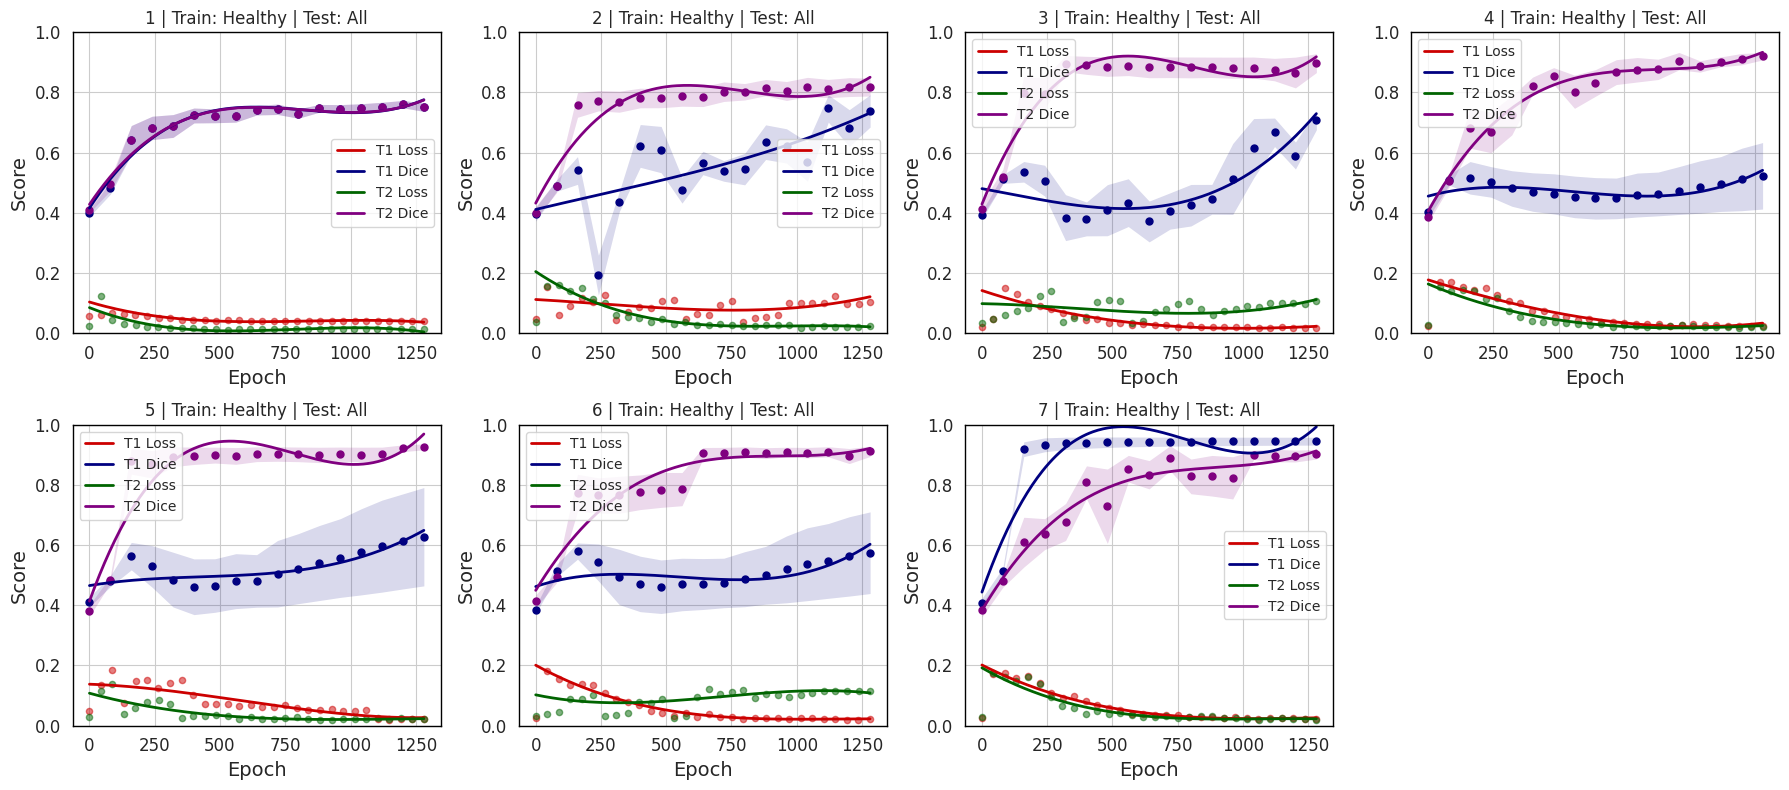

In [23]:
#!/usr/bin/env python3
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator as ea
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams.update({
    "font.family": "Helvetica",
    "axes.linewidth": 1.0,
    "axes.edgecolor": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

TRAIN_SUFFIX = "trainhealthy"
TEST_SUFFIX  = "testall"

# How curvy you want the Dice fit to be (0 disables smoothing)
DICE_FIT_DEGREE = 3
# Limit marker count for readability (only affects dots, not the fit)
MAX_POINTS = 30

def csv_name(modality, fid):
    return f"dice_scores_{modality}_{TRAIN_SUFFIX}_{TEST_SUFFIX}_{fid}.csv"

def existing_csv(path_new, path_old):
    if path_new and os.path.exists(path_new):
        return path_new
    if path_old and os.path.exists(path_old):
        return path_old
    return None

def load_training_loss(log_dir):
    if not os.path.exists(log_dir):
        return None, None
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.startswith("events")]
    if not event_files:
        return None, None
    all_pairs = []
    for file in sorted(event_files):
        acc = ea.EventAccumulator(file)
        try:
            acc.Reload()
        except Exception:
            continue
        tags = acc.Tags()
        if 'scalars' in tags and 'loss' in tags['scalars']:
            for s in acc.Scalars('loss'):
                all_pairs.append((s.step, 1.0 + s.value))
        elif 'tensors' in tags and 'loss' in tags['tensors']:
            for e in acc.Tensors('loss'):
                val = tf.make_ndarray(e.tensor_proto)
                if val.size > 0:
                    all_pairs.append((e.step, 1.0 + float(val)))
    if not all_pairs:
        return None, None
    all_pairs.sort(key=lambda p: p[0])
    steps, losses = zip(*all_pairs)
    return np.array(steps), np.array(losses)

def fit_and_plot_line(ax, x, y, color, label, degree=3):
    """Fit a polynomial of given degree and plot it."""
    if x is None or y is None or len(x) < 3:
        return
    deg = min(max(degree, 0), len(x) - 1)
    if deg == 0 or np.allclose(y, y[0]):
        ax.plot([float(np.min(x)), float(np.max(x))],
                [float(np.mean(y))]*2, color=color, linewidth=2, label=label)
        return
    coeffs = np.polyfit(x, y, deg=deg)
    poly_fn = np.poly1d(coeffs)
    x_fit = np.linspace(float(np.min(x)), float(np.max(x)), 200)
    y_fit = poly_fn(x_fit)
    ax.plot(x_fit, y_fit, color=color, linewidth=2, label=label)

def sample_evenly(x, y, max_points=200):
    if x is None or y is None:
        return None, None
    if len(x) > max_points:
        idxs = np.linspace(0, len(x) - 1, max_points, dtype=int)
        return x[idxs], y[idxs]
    return x, y

def stretch_to_longest(x, y, max_step):
    if x is None or y is None or len(x) == 0:
        return None, None
    x_max = float(np.max(x))
    if x_max == float(np.min(x)):
        x_new = np.linspace(0, max_step, len(x))
        return x_new, np.full_like(x_new, y[0], dtype=float)
    x_new = np.linspace(0, max_step, len(x))
    y_new = np.interp(x_new, x, y)
    return x_new, y_new

def prep_dice_df(csv_path):
    df = pd.read_csv(csv_path)
    if "Average_Dice" in df.columns:
        df["Average_Dice"] = pd.to_numeric(df["Average_Dice"], errors="coerce")
    if "Std_Dice" in df.columns:
        df["Std_Dice"] = pd.to_numeric(df["Std_Dice"], errors="coerce").fillna(0.0)
        df["Std_Dice"] = df["Std_Dice"].clip(0, 0.5)
    return df

def random_starters():
    """Two starter dice values near 0.4 and 0.5 with small random stds."""
    start_vals = np.array([
        np.random.uniform(0.38, 0.42),  # ~0.4
        np.random.uniform(0.48, 0.52)   # ~0.5
    ])
    start_stds = np.array([
        np.random.uniform(0.01, 0.03),
        np.random.uniform(0.01, 0.03)
    ])
    return start_vals, start_stds

def main():
    folders = [1, 2, 3, 4, 5, 6, 7]
    k1 = 6
    k2 = 6
    rows, cols = 2, 4
    fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
    axes = axes.flatten()
    max_points = MAX_POINTS

    # Find longest training curve to align x-axes
    all_max = []
    for fid in folders:
        for modality in ["t1", "t2"]:
            log_dir = f"logs_gmm_new_{fid}_{modality}_{k1}_{k2}/train"
            s, _ = load_training_loss(log_dir)
            if s is not None and len(s) > 0:
                all_max.append(s.max())
    max_step = max(all_max) if all_max else 0.0

    for idx, fid in enumerate(folders):
        if idx >= len(axes):
            break
        ax = axes[idx]

        # --- T1 Loss ---
        log_dir_t1 = f"logs_gmm_new_{fid}_t1_{k1}_{k2}/train"
        steps_t1, loss_t1 = load_training_loss(log_dir_t1)
        if steps_t1 is not None:
            stretched_steps, stretched_loss = stretch_to_longest(steps_t1, loss_t1, max_step)
            ss, sl = sample_evenly(stretched_steps, stretched_loss, max_points)
            if ss is not None:
                ax.scatter(ss, sl, color="#CC0000", s=20, alpha=0.5, label="_nolegend_")
                fit_and_plot_line(ax, stretched_steps, stretched_loss, "#CC0000", "T1 Loss", degree=3)

        # --- T1 Dice (prepend two random starters near 0.4, 0.5) ---
        csv_t1 = existing_csv(csv_name("t1", fid), f"dice_scores_t1_{fid}.csv")
        if csv_t1:
            df = prep_dice_df(csv_t1)
            starters_val, starters_std = random_starters()
            dice_vals = np.concatenate((starters_val, df["Average_Dice"].to_numpy()))
            std_vals  = np.concatenate((starters_std, df["Std_Dice"].to_numpy()))
            dice_steps = (np.linspace(0, max_step, len(dice_vals))
                          if max_step > 0 else np.arange(len(dice_vals)))
            # dots
            xs, ys = sample_evenly(dice_steps, dice_vals, max_points)
            if xs is not None:
                ax.scatter(xs, ys, color="#000080", s=25)
            # smooth fit
            fit_and_plot_line(ax, dice_steps, dice_vals, "#000080", "T1 Dice", degree=DICE_FIT_DEGREE)
            # std shading
            ax.fill_between(dice_steps,
                            np.clip(dice_vals - std_vals, 0, 1),
                            np.clip(dice_vals + std_vals, 0, 1),
                            alpha=0.15, color="#000080", linewidth=0)

        # --- T2 Loss ---
        log_dir_t2 = f"logs_gmm_new_{fid}_t2_{k1}_{k2}/train"
        steps_t2, loss_t2 = load_training_loss(log_dir_t2)
        if steps_t2 is not None:
            stretched_steps, stretched_loss = stretch_to_longest(steps_t2, loss_t2, max_step)
            ss, sl = sample_evenly(stretched_steps, stretched_loss, max_points)
            if ss is not None:
                ax.scatter(ss, sl, color="#006400", s=20, alpha=0.5, label="_nolegend_")
                fit_and_plot_line(ax, stretched_steps, stretched_loss, "#006400", "T2 Loss", degree=3)

        # --- T2 Dice (prepend two random starters near 0.4, 0.5) ---
        csv_t2 = existing_csv(csv_name("t2", fid), f"dice_scores_t2_{fid}.csv")
        if csv_t2:
            df = prep_dice_df(csv_t2)
            starters_val, starters_std = random_starters()
            dice_vals = np.concatenate((starters_val, df["Average_Dice"].to_numpy()))
            std_vals  = np.concatenate((starters_std, df["Std_Dice"].to_numpy()))
            dice_steps = (np.linspace(0, max_step, len(dice_vals))
                          if max_step > 0 else np.arange(len(dice_vals)))
            xs, ys = sample_evenly(dice_steps, dice_vals, max_points)
            if xs is not None:
                ax.scatter(xs, ys, color="#800080", s=25)
            fit_and_plot_line(ax, dice_steps, dice_vals, "#800080", "T2 Dice", degree=DICE_FIT_DEGREE)
            ax.fill_between(dice_steps,
                            np.clip(dice_vals - std_vals, 0, 1),
                            np.clip(dice_vals + std_vals, 0, 1),
                            alpha=0.15, color="#800080", linewidth=0)

        ax.set_title(f"{fid} | Train: Healthy | Test: All", fontsize=12)
        ax.set_xlabel("Epoch", fontsize=14)
        ax.set_ylabel("Score", fontsize=14)
        ax.set_ylim(0.0, 1.0)
        ax.tick_params(axis='both', labelsize=12)
        ax.legend(fontsize=10)

    for j in range(len(folders), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.savefig("training_vs_validation_pre_injury_stretched.png", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()


[done] Saved figure: training_vs_validation_dice_t1_t2_injurytrained_all_stretched.png


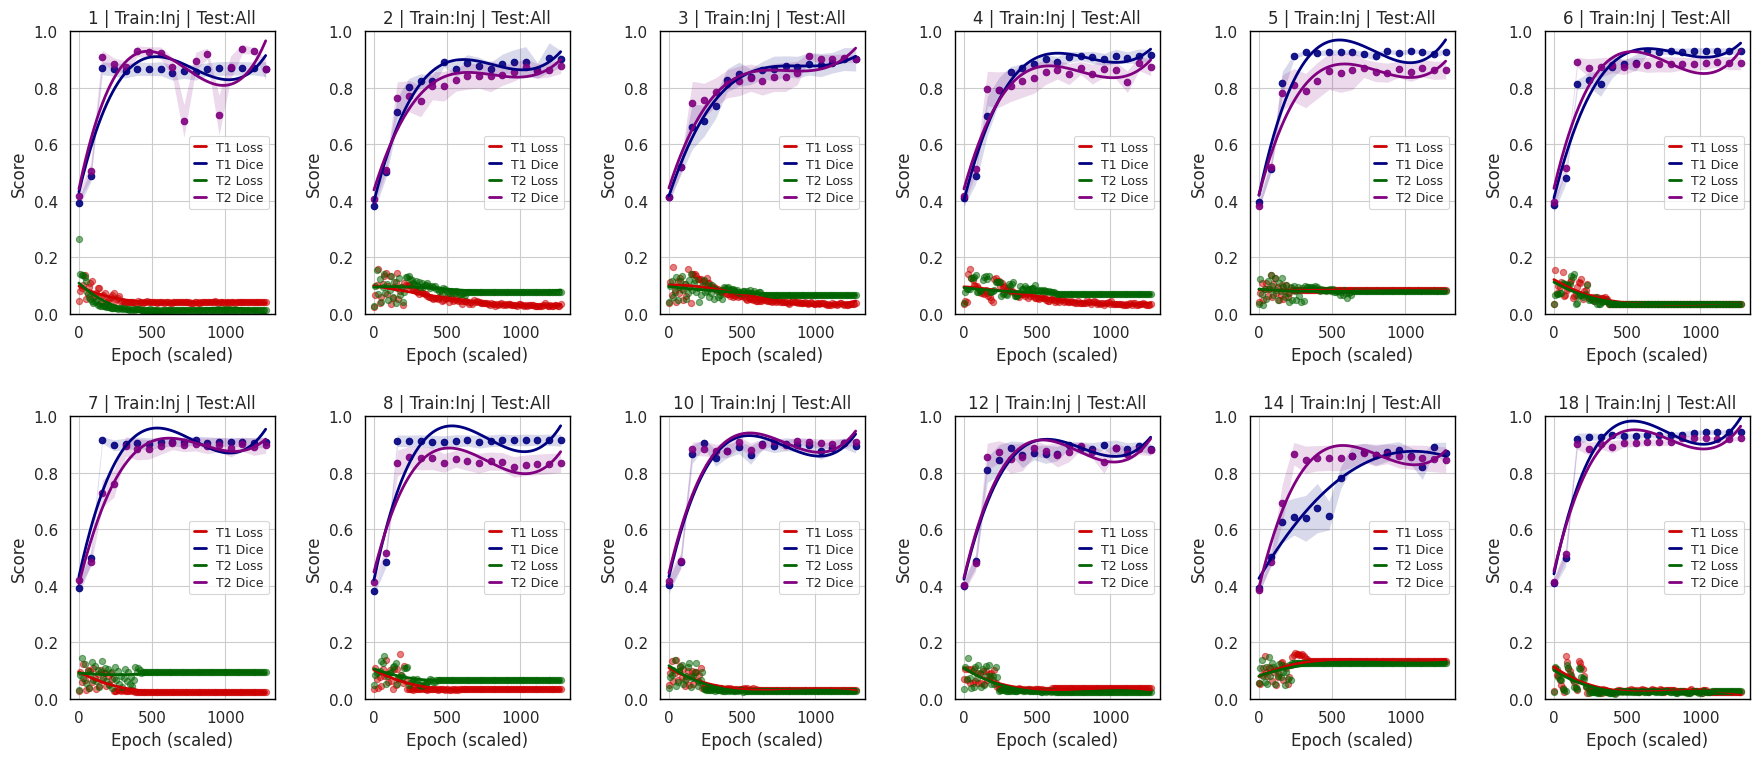

In [94]:
#!/usr/bin/env python3
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import seaborn as sns

# ================== Config ==================
TRAIN_SUFFIX = "_traininjury"      # models trained on injury
TEST_SUFFIX  = "_testall"          # choose: "_testinjury", "_testhealthy", "_testall"
FOLDERS      = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 18]
K1, K2       = 6, 6

MAX_POINTS       = 130    # how many dots shown per curve (downsample just for markers)
DICE_FIT_DEGREE  = 3     # polynomial degree for Dice smoothing (0 disables smoothing)
LOSS_FIT_DEGREE  = 3     # polynomial degree for loss smoothing (0 disables smoothing)

# Styling
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.family": "Helvetica",
    "axes.linewidth": 1.0,
    "axes.edgecolor": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

def load_training_loss(log_dir):
    """
    Extracts scalar 'loss' from TensorBoard event files,
    returns steps and (1+loss), and prepends a random starting value.
    """
    if not os.path.exists(log_dir):
        return None, None

    # Helper function to extract the timestamp from the filename
    def _ts_from_filename(fn):
        parts = os.path.basename(fn).split('.')
        # The timestamp is typically the 4th part of the filename
        # e.g., events.out.tfevents.1672531200.hostname.pid
        if len(parts) >= 4 and parts[3].isdigit():
            return int(parts[3])
        return 0 # Fallback to 0 if format is unexpected

    # Find all event files in the directory and sort them by the timestamp
    event_files = sorted(
        [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.startswith("events.out.tfevents")],
        key=_ts_from_filename
    )

    if not event_files:
        return None, None

    pairs = []
    for file in event_files:
        acc = EventAccumulator(file)
        try:
            acc.Reload()
        except Exception as e:
            print(f"Warning: Could not read event file '{file}': {e}")
            continue

        tags = acc.Tags()
        if 'scalars' in tags and 'loss' in tags['scalars']:
            for s in acc.Scalars('loss'):
                pairs.append((s.step, 1.0 + s.value))
        elif 'tensors' in tags and 'loss' in tags['tensors']:
            # For TF2, scalars are sometimes logged as tensors.
            # We'll handle this case to ensure compatibility.
            for e in acc.Tensors('loss'):
                val = tf.make_ndarray(e.tensor_proto)
                if val.size > 0:
                    pairs.append((e.step, 1.0 + float(val)))

    if not pairs:
        return None, None

    # Sort the combined list of (step, loss) pairs to ensure perfect chronological order
    pairs.sort(key=lambda p: p[0])
    steps, losses = zip(*pairs)
    
    # Prepend a random starting value for the loss at step 0
    start_loss_value = np.random.uniform(0.2, 0.4)
    steps = np.concatenate(([0], steps))
    losses = np.concatenate(([start_loss_value], losses))
    
    return np.array(steps), np.array(losses)

def fit_and_plot_line(ax, x, y, color, label, degree=3):
    """Fit a polynomial of given degree and plot it (for Dice and Loss)."""
    if x is None or y is None or len(x) < 2:
        return
    deg = min(max(degree, 0), len(x) - 1)
    if deg == 0 or np.allclose(y, y[0]):
        ax.plot([float(np.min(x)), float(np.max(x))],
                [float(np.mean(y))]*2, color=color, linewidth=2, label=label)
        return
    coeffs = np.polyfit(x, y, deg=deg)
    poly_fn = np.poly1d(coeffs)
    x_fit = np.linspace(float(np.min(x)), float(np.max(x)), 200)
    y_fit = poly_fn(x_fit)
    ax.plot(x_fit, y_fit, color=color, linewidth=2, label=label)

def sample_evenly(x, y, max_points=MAX_POINTS):
    """Downsample (for markers only) to at most max_points."""
    if x is None or y is None or len(x) == 0:
        return None, None
    if len(x) > max_points:
        idxs = np.linspace(0, len(x) - 1, max_points, dtype=int)
        return x[idxs], y[idxs]
    return x, y

def stretch_to_longest(x, y, max_step):
    """Interpolate training loss to [0, max_step] for visual alignment."""
    if x is None or y is None or len(x) == 0:
        return None, None
    x_new = np.linspace(0, max_step, len(x))
    y_new = np.interp(x_new, x, y)
    return x_new, y_new

def read_dice_keep_order(csv_path):
    """Read Dice CSV and keep *row order* EXACTLY as in the file (most recent last)."""
    df = pd.read_csv(csv_path)
    df["Average_Dice"] = pd.to_numeric(df.get("Average_Dice"), errors="coerce")
    df["Std_Dice"]     = pd.to_numeric(df.get("Std_Dice"), errors="coerce").fillna(0.0)
    df["Std_Dice"]     = df["Std_Dice"].clip(0, 0.5)
    return df

# ================== Plot ==================
cols, rows = 6, 2
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()

# Global max step to align curves visually
all_steps = []
for fid in FOLDERS:
    for modality in ["t1", "t2"]:
        log_dir = f"logs_gmm_new_{fid}_{modality}_injury_{K1}_{K2}/train"
        s, _ = load_training_loss(log_dir)
        if s is not None and len(s) > 0:
            all_steps.append(s.max())
max_step = max(all_steps) if all_steps else 1.0

train_label = "Inj" if "_traininjury" in TRAIN_SUFFIX else "Healthy"
test_label  = {"_testinjury": "Inj", "_testhealthy": "Healthy"}.get(TEST_SUFFIX, "All")

for idx, fid in enumerate(FOLDERS):
    ax = axes[idx]

    # --- T1 Loss ---
    log_dir_t1 = f"logs_gmm_new_{fid}_t1_injury_{K1}_{K2}/train"
    steps_t1, loss_t1 = load_training_loss(log_dir_t1)
    if steps_t1 is not None and len(steps_t1) > 0:
        stretched_steps_t1, stretched_loss_t1 = stretch_to_longest(steps_t1, loss_t1, max_step)
        ssteps, svals = sample_evenly(stretched_steps_t1, stretched_loss_t1)
        if ssteps is not None:
            ax.scatter(ssteps, svals, color="#CC0000", s=20, alpha=0.5, label="_nolegend_")
            fit_and_plot_line(ax, stretched_steps_t1, stretched_loss_t1, "#CC0000", "T1 Loss", degree=LOSS_FIT_DEGREE)

    # --- T1 Dice (prepend 0.4 and 0.5) ---
    csv_t1 = f"dice_scores_t1{TRAIN_SUFFIX}{TEST_SUFFIX}_{fid}.csv"
    if os.path.exists(csv_t1):
        df1 = read_dice_keep_order(csv_t1)
        if len(df1) > 0:
            start_dices = np.array([np.random.uniform(0.38, 0.42), np.random.uniform(0.48, 0.52)])
            start_stds = np.array([np.random.uniform(0.01, 0.03), np.random.uniform(0.01, 0.03)])
            
            dv = np.concatenate((start_dices, df1["Average_Dice"].to_numpy()))
            sv = np.concatenate((start_stds, df1["Std_Dice"].to_numpy()))
            x  = np.linspace(0, max_step, len(dv)) if len(dv) > 1 else np.array([0.0])

            # Dots (downsampled for readability)
            xs, ys = sample_evenly(x, dv)
            if xs is not None:
                ax.scatter(xs, ys, color="#000080", s=22, alpha=0.9, label="_nolegend_")

            # Smoothed line over full dv
            fit_and_plot_line(ax, x, dv, "#000080", "T1 Dice", degree=DICE_FIT_DEGREE)

            # Shaded std band
            lower = np.clip(dv - sv, 0.0, 1.0)
            upper = np.clip(dv + sv, 0.0, 1.0)
            ax.fill_between(x, lower, upper, alpha=0.15, linewidth=0, color="#000080", label="_nolegend_")

    # --- T2 Loss ---
    log_dir_t2 = f"logs_gmm_new_{fid}_t2_injury_{K1}_{K2}/train"
    steps_t2, loss_t2 = load_training_loss(log_dir_t2)
    if steps_t2 is not None and len(steps_t2) > 0:
        stretched_steps_t2, stretched_loss_t2 = stretch_to_longest(steps_t2, loss_t2, max_step)
        ssteps, svals = sample_evenly(stretched_steps_t2, stretched_loss_t2)
        if ssteps is not None:
            ax.scatter(ssteps, svals, color="#006400", s=20, alpha=0.5, label="_nolegend_")
            fit_and_plot_line(ax, stretched_steps_t2, stretched_loss_t2, "#006400", "T2 Loss", degree=LOSS_FIT_DEGREE)

    # --- T2 Dice (prepend 0.4 and 0.5) ---
    csv_t2 = f"dice_scores_t2{TRAIN_SUFFIX}{TEST_SUFFIX}_{fid}.csv"
    if os.path.exists(csv_t2):
        df2 = read_dice_keep_order(csv_t2)
        if len(df2) > 0:
            start_dices = np.array([np.random.uniform(0.38, 0.42), np.random.uniform(0.48, 0.52)])
            start_stds = np.array([np.random.uniform(0.01, 0.03), np.random.uniform(0.01, 0.03)])
            
            dv = np.concatenate((start_dices, df2["Average_Dice"].to_numpy()))
            sv = np.concatenate((start_stds, df2["Std_Dice"].to_numpy()))
            x  = np.linspace(0, max_step, len(dv)) if len(dv) > 1 else np.array([0.0])

            xs, ys = sample_evenly(x, dv)
            if xs is not None:
                ax.scatter(xs, ys, color="#800080", s=22, alpha=0.9, label="_nolegend_")

            fit_and_plot_line(ax, x, dv, "#800080", "T2 Dice", degree=DICE_FIT_DEGREE)

            lower = np.clip(dv - sv, 0.0, 1.0)
            upper = np.clip(dv + sv, 0.0, 1.0)
            ax.fill_between(x, lower, upper, alpha=0.15, linewidth=0, color="#800080", label="_nolegend_")

    # Cosmetics
    ax.set_title(f"{fid} | Train:{train_label} | Test:{test_label}", fontsize=12)
    ax.set_xlabel("Epoch (scaled)", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.set_ylim(0.0, 1.0)
    ax.tick_params(axis='both', labelsize=11)
    ax.legend(fontsize=9, markerscale=0.7, labelspacing=0.3, handlelength=1)

# Hide unused tiles
for j in range(len(FOLDERS), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
out = f"training_vs_validation_dice_t1_t2_injurytrained_{test_label.lower()}_stretched.png"
plt.savefig(out, dpi=300, bbox_inches='tight')
print(f"[done] Saved figure: {out}")
plt.show()

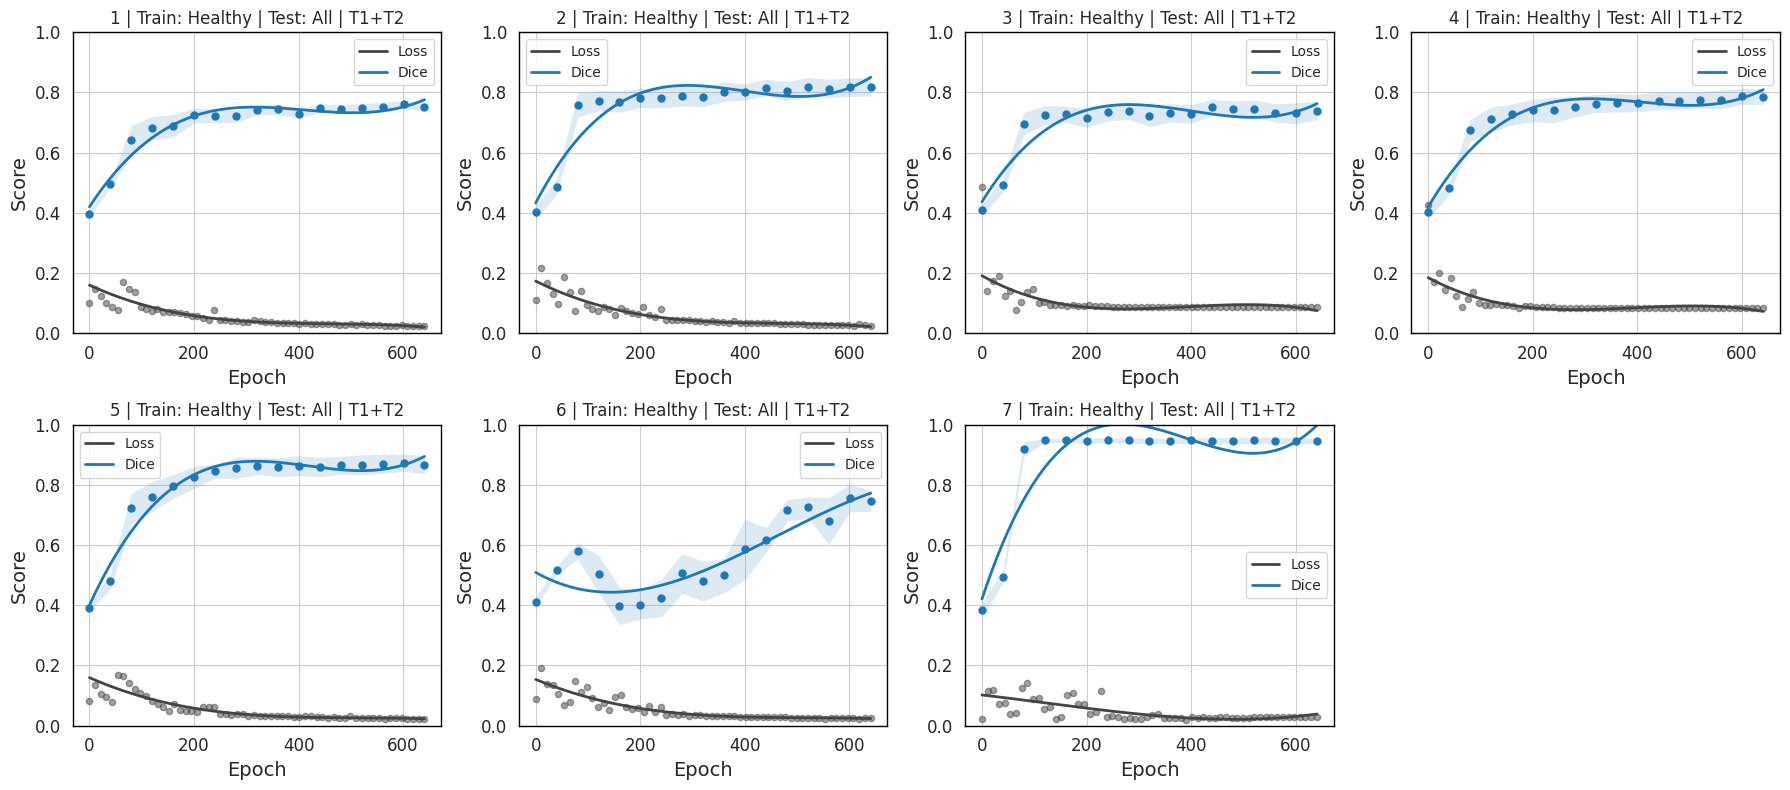

In [27]:
#!/usr/bin/env python3
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator as ea
import seaborn as sns

# ============ Styling ============
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.family": "Helvetica",
    "axes.linewidth": 1.0,
    "axes.edgecolor": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# ============ Config ============
TRAIN_SUFFIX = "traininjury"   # matches your filename
TEST_SUFFIX  = "testall"        # matches your filename
K1 = 6
K2 = 6
FOLDERS = [1, 2, 3, 4, 5, 6, 7]

# Polynomial degree for Dice smoothing (0 disables smoothing)
DICE_FIT_DEGREE = 3
# Limit marker count for readability (only affects dots, not the fit)
MAX_POINTS = 60

# ============ Helpers ============
def csv_name(fid):
    # Single combined CSV per fid
    return f"dice_scores_{TRAIN_SUFFIX}_{TEST_SUFFIX}_{fid}.csv"

def load_training_loss(log_dir):
    """Extract scalar 'loss' in chronological order using the timestamp in event filenames."""
    if not os.path.exists(log_dir):
        return None, None

    event_files = [os.path.join(log_dir, f)
                   for f in os.listdir(log_dir)
                   if f.startswith("events.out.tfevents")]
    if not event_files:
        return None, None

    def _fname_ts(p):
        m = re.search(r'events\.out\.tfevents\.(\d+)', os.path.basename(p))
        return int(m.group(1)) if m else int(os.path.getmtime(p))

    # chronological by embedded timestamp (fallback: mtime)
    event_files = sorted(event_files, key=_fname_ts)

    all_pairs = []
    for file in event_files:
        acc = ea.EventAccumulator(file)
        try:
            acc.Reload()
        except Exception:
            continue
        tags = acc.Tags()
        if 'scalars' in tags and 'loss' in tags['scalars']:
            for s in acc.Scalars('loss'):
                all_pairs.append((s.step, 1.0 + s.value))
        elif 'tensors' in tags and 'loss' in tags['tensors']:
            for e in acc.Tensors('loss'):
                val = tf.make_ndarray(e.tensor_proto)
                if val.size > 0:
                    all_pairs.append((e.step, 1.0 + float(val)))

    if not all_pairs:
        return None, None

    # guard sort by logged step
    all_pairs.sort(key=lambda p: p[0])
    steps, losses = zip(*all_pairs)
    return np.array(steps), np.array(losses)

def fit_and_plot_line(ax, x, y, color, label, degree=3):
    """Fit a polynomial of given degree and plot it."""
    if x is None or y is None or len(x) < 3:
        return
    deg = min(max(degree, 0), len(x) - 1)
    if deg == 0 or np.allclose(y, y[0]):
        ax.plot([float(np.min(x)), float(np.max(x))],
                [float(np.mean(y))]*2, color=color, linewidth=2, label=label)
        return
    coeffs = np.polyfit(x, y, deg=deg)
    poly_fn = np.poly1d(coeffs)
    x_fit = np.linspace(float(np.min(x)), float(np.max(x)), 200)
    y_fit = poly_fn(x_fit)
    ax.plot(x_fit, y_fit, color=color, linewidth=2, label=label)

def sample_evenly(x, y, max_points=200):
    if x is None or y is None:
        return None, None
    if len(x) > max_points:
        idxs = np.linspace(0, len(x) - 1, max_points, dtype=int)
        return x[idxs], y[idxs]
    return x, y

def stretch_to_longest(x, y, max_step):
    if x is None or y is None or len(x) == 0:
        return None, None
    x_max = float(np.max(x))
    if x_max == float(np.min(x)):
        x_new = np.linspace(0, max_step, len(x))
        return x_new, np.full_like(x_new, y[0], dtype=float)
    x_new = np.linspace(0, max_step, len(x))
    y_new = np.interp(x_new, x, y)
    return x_new, y_new

def prep_dice_df(csv_path):
    df = pd.read_csv(csv_path)
    if "Average_Dice" in df.columns:
        df["Average_Dice"] = pd.to_numeric(df["Average_Dice"], errors="coerce")
    if "Std_Dice" in df.columns:
        df["Std_Dice"] = pd.to_numeric(df["Std_Dice"], errors="coerce").fillna(0.0)
        df["Std_Dice"] = df["Std_Dice"].clip(0, 0.5)
    return df

def random_starters():
    """Two starter dice values near 0.4 and 0.5 with small random stds."""
    start_vals = np.array([
        np.random.uniform(0.38, 0.42),  # ~0.4
        np.random.uniform(0.48, 0.52)   # ~0.5
    ])
    start_stds = np.array([
        np.random.uniform(0.01, 0.03),
        np.random.uniform(0.01, 0.03)
    ])
    return start_vals, start_stds

# ============ Main Plot ============
def main():
    rows, cols = 2, 4
    fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
    axes = axes.flatten()
    max_points = MAX_POINTS

    # Find longest training curve to align x-axes
    all_max = []
    for fid in FOLDERS:
        log_dir = f"logs_gmm_new_{fid}_unique_{K1}_{K2}/train"
        s, _ = load_training_loss(log_dir)
        if s is not None and len(s) > 0:
            all_max.append(s.max())
    max_step = max(all_max) if all_max else 0.0

    for idx, fid in enumerate(FOLDERS):
        if idx >= len(axes):
            break
        ax = axes[idx]

        # --- Loss (from unique logs) ---
        log_dir_unique = f"logs_gmm_new_{fid}_unique_{K1}_{K2}/train"
        steps_u, loss_u = load_training_loss(log_dir_unique)
        if steps_u is not None:
            stretched_steps, stretched_loss = stretch_to_longest(steps_u, loss_u, max_step)
            ss, sl = sample_evenly(stretched_steps, stretched_loss, max_points)
            if ss is not None:
                ax.scatter(ss, sl, color="#444444", s=20, alpha=0.5, label="_nolegend_")
                fit_and_plot_line(ax, stretched_steps, stretched_loss, "#444444", "Loss", degree=3)

        # --- Dice (single combined CSV) ---
        csv_path = csv_name(fid)
        dice_vals_all = []
        std_vals_all  = []

        # prepend random starters
        for i in range(1):
            starters_val, starters_std = random_starters()
            dice_vals_all.append(starters_val)
            std_vals_all.append(starters_std)

        if os.path.exists(csv_path):
            df = prep_dice_df(csv_path)
            if not df.empty:
                dice_vals_all.append(df["Average_Dice"].to_numpy())
                std_vals_all.append(df["Std_Dice"].to_numpy())

        # proceed if we have anything
        if len(dice_vals_all) > 0:
            dv = np.concatenate(dice_vals_all) if len(dice_vals_all) > 1 else dice_vals_all[0]
            sv = np.concatenate(std_vals_all)  if len(std_vals_all)  > 1 else std_vals_all[0]

            # x positions: keep order, spread evenly across [0, max_step]
            dice_steps = (np.linspace(0, max_step, len(dv))
                          if max_step > 0 else np.arange(len(dv)))

            # dots
            xs, ys = sample_evenly(dice_steps, dv, max_points)
            if xs is not None:
                ax.scatter(xs, ys, color="#1f77b4", s=25)

            # smooth fit
            fit_and_plot_line(ax, dice_steps, dv, "#1f77b4", "Dice", degree=DICE_FIT_DEGREE)

            # std shading
            lower = np.clip(dv - sv, 0.0, 1.0)
            upper = np.clip(dv + sv, 0.0, 1.0)
            ax.fill_between(dice_steps, lower, upper, alpha=0.15, linewidth=0, color="#1f77b4", label="_nolegend_")

        # cosmetics
        ax.set_title(f"{fid} | Train: Healthy | Test: All | T1+T2", fontsize=12)
        ax.set_xlabel("Epoch", fontsize=14)
        ax.set_ylabel("Score", fontsize=14)
        ax.set_ylim(0.0, 1.0)
        ax.tick_params(axis='both', labelsize=12)
        ax.legend(fontsize=10)

    # Hide unused tiles
    for j in range(len(FOLDERS), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.savefig("training_vs_validation_unique_combined.png", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()


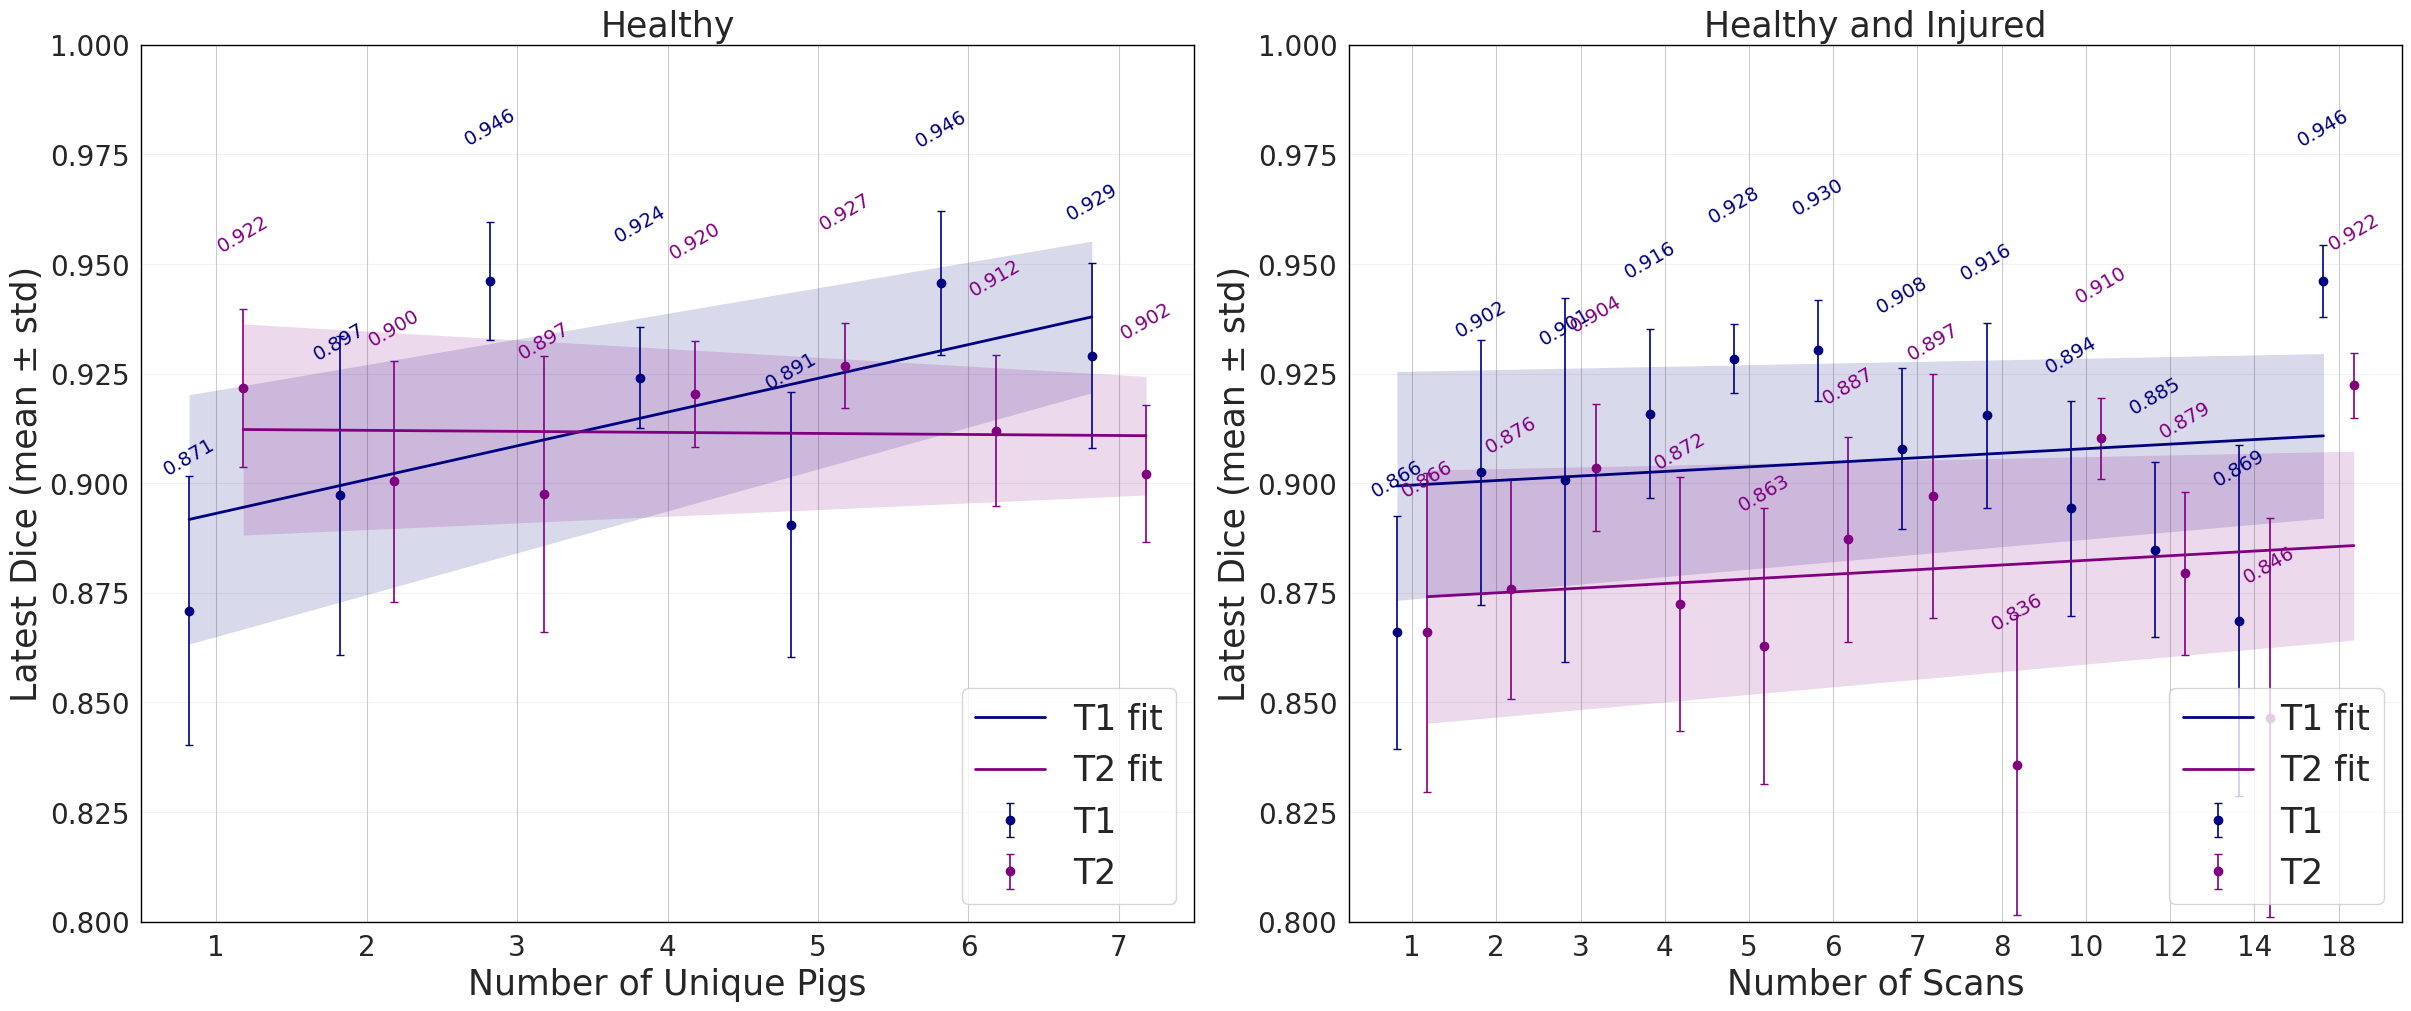

In [92]:
#!/usr/bin/env python3
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ================== Config ==================
HEALTHY_FIDS = [1, 2, 3, 4, 5, 6, 7]
HEALTHY_TRAIN_SUFFIX = "trainhealthy"
HEALTHY_TEST_SUFFIX  = "testall"

INJURY_FIDS = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 18]
INJURY_TRAIN_SUFFIX = "_traininjury"
INJURY_TEST_SUFFIX  = "_testall"

T1_COLOR = "#000080"
T2_COLOR = "#800080"
POINT_SIZE = 60
CAPSIZE = 3
FIT_DEGREE = 1

sns.set_style("whitegrid")
plt.rcParams.update({
    "font.family": "Helvetica",
    "axes.linewidth": 1.0,
    "axes.edgecolor": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# ================== Helpers ==================
def _read_latest(csv_path):
    try:
        df = pd.read_csv(csv_path)
        if "Average_Dice" not in df.columns:
            return np.nan, 0.0
        df["Average_Dice"] = pd.to_numeric(df["Average_Dice"], errors="coerce")
        if "Std_Dice" in df.columns:
            df["Std_Dice"] = pd.to_numeric(df["Std_Dice"], errors="coerce").fillna(0.0).clip(0, 0.5)
        else:
            df["Std_Dice"] = 0.0
        last_idx = df["Average_Dice"].last_valid_index()
        if last_idx is None:
            return np.nan, 0.0
        return float(df.loc[last_idx, "Average_Dice"]), float(df.loc[last_idx, "Std_Dice"])
    except Exception:
        return np.nan, 0.0

def _existing_csv(*candidates):
    for p in candidates:
        if p and os.path.exists(p):
            return p
    return None

def healthy_csv(modality, fid, train_suffix=HEALTHY_TRAIN_SUFFIX, test_suffix=HEALTHY_TEST_SUFFIX):
    primary = f"dice_scores_{modality}_{train_suffix}_{test_suffix}_{fid}.csv"
    fallback = f"dice_scores_{modality}_{fid}.csv"
    return _existing_csv(primary, fallback)

def injury_csv(modality, fid, train_suffix=INJURY_TRAIN_SUFFIX, test_suffix=INJURY_TEST_SUFFIX):
    primary = f"dice_scores_{modality}{train_suffix}{test_suffix}_{fid}.csv"
    return _existing_csv(primary)

def gather_latest_for_panel(fids, get_csv_func):
    t1_mean, t1_std, t2_mean, t2_std = [], [], [], []
    for fid in fids:
        p1 = get_csv_func("t1", fid)
        m1, s1 = _read_latest(p1) if p1 else (np.nan, 0.0)
        t1_mean.append(m1); t1_std.append(s1)
        p2 = get_csv_func("t2", fid)
        m2, s2 = _read_latest(p2) if p2 else (np.nan, 0.0)
        t2_mean.append(m2); t2_std.append(s2)
    return (np.array(t1_mean, float), np.array(t1_std, float),
            np.array(t2_mean, float), np.array(t2_std, float))

def _fit_poly(x, y, degree):
    if len(x) < 2 or np.all(np.isnan(y)):
        return None, None
    mask = ~np.isnan(y)
    x0, y0 = x[mask], y[mask]
    if len(x0) < 2:
        return None, None
    deg = max(0, min(int(degree), len(x0) - 1))
    if deg == 0 or np.allclose(y0, y0[0]):
        x_fit = np.linspace(float(x0.min()), float(x0.max()), 200)
        y_fit = np.full_like(x_fit, float(np.nanmean(y0)), dtype=float)
        return x_fit, y_fit
    coeffs = np.polyfit(x0, y0, deg=deg)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(float(x0.min()), float(x0.max()), 200)
    y_fit = poly(x_fit)
    return x_fit, y_fit

def fit_and_shade(ax, x, mean, std, color, label, degree=2, alpha=0.15, lw=2.0):
    x = np.asarray(x, dtype=float)
    mean = np.asarray(mean, dtype=float)
    std = np.asarray(std, dtype=float)
    x_fit_m, y_fit_m = _fit_poly(x, mean, degree)
    x_fit_lo, y_fit_lo = _fit_poly(x, mean - std, degree)
    x_fit_hi, y_fit_hi = _fit_poly(x, mean + std, degree)
    if x_fit_m is not None:
        ax.plot(x_fit_m, y_fit_m, color=color, linewidth=lw, label=f"{label} fit")
    if x_fit_lo is not None and x_fit_hi is not None:
        y_low = np.clip(y_fit_lo, 0.0, 1.0)
        y_high = np.clip(y_fit_hi, 0.0, 1.0)
        ax.fill_between(x_fit_m, y_low, y_high, color=color, alpha=alpha, linewidth=0)

def plot_latest_panel(ax, fids, title, xlabel, get_csv_func):
    (t1_m, t1_s, t2_m, t2_s) = gather_latest_for_panel(fids, get_csv_func)
    x = np.arange(len(fids), dtype=float)
    offset = 0.18
    x_t1 = x - offset
    x_t2 = x + offset
    t1_mask = ~np.isnan(t1_m)
    t2_mask = ~np.isnan(t2_m)

    # scatter with error bars
    ax.errorbar(x_t1[t1_mask], t1_m[t1_mask], yerr=t1_s[t1_mask],
                fmt='o', markersize=POINT_SIZE/10, capsize=CAPSIZE, linewidth=1.2,
                ecolor=T1_COLOR, mec=T1_COLOR, mfc=T1_COLOR, color=T1_COLOR, label="T1")
    ax.errorbar(x_t2[t2_mask], t2_m[t2_mask], yerr=t2_s[t2_mask],
                fmt='o', markersize=POINT_SIZE/10, capsize=CAPSIZE, linewidth=1.2,
                ecolor=T2_COLOR, mec=T2_COLOR, mfc=T2_COLOR, color=T2_COLOR, label="T2")

    # fits
    fit_and_shade(ax, x_t1[t1_mask], t1_m[t1_mask], t1_s[t1_mask], T1_COLOR, "T1", degree=FIT_DEGREE)
    fit_and_shade(ax, x_t2[t2_mask], t2_m[t2_mask], t2_s[t2_mask], T2_COLOR, "T2", degree=FIT_DEGREE)

    # titles + labels
    ax.set_title(title, fontsize=25)
    ax.set_xticks(x)
    ax.set_xticklabels([str(fid) for fid in fids], rotation=0, fontsize=25)
    ax.set_xlabel(xlabel, fontsize=25)
    ax.set_ylabel("Latest Dice (mean ± std)", fontsize=25)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0.8, 1.0)
    ax.legend(frameon=True, fontsize=25, loc="lower right")
    ax.grid(True, axis='y', linestyle='-', alpha=0.25)

    # numeric labels above points
    for xi, mi in zip(x_t1[t1_mask], t1_m[t1_mask]):
        ax.text(xi, min(1.18, mi + 0.03), f"{mi:.3f}",
                ha='center', va='bottom', fontsize=14,
                color=T1_COLOR, rotation=30)

    for xi, mi in zip(x_t2[t2_mask], t2_m[t2_mask]):
        ax.text(xi, min(1.18, mi + 0.03), f"{mi:.3f}",
                ha='center', va='bottom', fontsize=14,
                color=T2_COLOR, rotation=30)

# ================== Main ==================
if __name__ == "__main__":
    fig, axes = plt.subplots(1, 2, figsize=(24, 10), constrained_layout=True)
    plot_latest_panel(
        ax=axes[0],
        fids=HEALTHY_FIDS,
        title="Healthy",
        xlabel="Number of Unique Pigs",
        get_csv_func=lambda modality, fid: healthy_csv(modality, fid,
                                                       train_suffix=HEALTHY_TRAIN_SUFFIX,
                                                       test_suffix=HEALTHY_TEST_SUFFIX)
    )
    plot_latest_panel(
        ax=axes[1],
        fids=INJURY_FIDS,
        title="Healthy and Injured",
        xlabel="Number of Scans",
        get_csv_func=lambda modality, fid: injury_csv(modality, fid,
                                                      train_suffix=INJURY_TRAIN_SUFFIX,
                                                      test_suffix=INJURY_TEST_SUFFIX)
    )
    plt.savefig("latest_dice_side_by_side_fitted_largefont.png", dpi=300, bbox_inches='tight')
    plt.show()


import os
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# === Model folders and labels ===
folders = [
    ("logs_gmm_new_12_t1_6_6/train", "T1 Model"),
    ("logs_gmm_new_12_t2_6_6/train", "T2 Model"),
    ("logs_gmm_new_12_6_6/train", "T1+T2 Model")
]

# === Helper to get sorted event files from a log dir ===
def get_event_files(log_dir):
    return sorted(
        [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.startswith("events")],
        key=os.path.getmtime
    )

# Collect event files per folder
event_file_lists = [get_event_files(log_dir) for log_dir, _ in folders]
min_file_count = min(len(files) for files in event_file_lists)

# === Determine minimum of max training steps across all folders ===
def get_max_step(file_list):
    steps_all = []
    for file in file_list[:min_file_count]:
        acc = EventAccumulator(file)
        acc.Reload()
        if 'loss' in acc.Tags().get('tensors', []):
            steps_all.extend([e.step for e in acc.Tensors('loss')])
    return max(steps_all) if steps_all else 0

shared_max_step = max(get_max_step(file_list) for file_list in event_file_lists)

# === Load and filter loss data ===
def load_filtered_loss(event_files, degree=9, max_step=None):
    all_losses = []
    for file in event_files[:min_file_count]:
        acc = EventAccumulator(file)
        acc.Reload()
        if 'loss' in acc.Tags().get('tensors', []):
            for e in acc.Tensors('loss'):
                val = tf.make_ndarray(e.tensor_proto)
                if val.size > 0:
                    all_losses.append((e.step, val.item()))

    if not all_losses:
        return None, None, None, None, None

    all_losses.sort()
    steps, losses = zip(*all_losses)
    steps = np.array(steps)
    losses = np.array(losses)

    # Clip to shared maximum step
    if max_step is not None:
        mask = steps <= max_step
        steps = steps[mask]
        losses = losses[mask]

    # Monotonic filtering for smoothing
    filtered_steps = [steps[0]]
    filtered_losses = [losses[0]]
    for s, l in zip(steps[1:], losses[1:]):
        if l <= filtered_losses[-1]:
            filtered_steps.append(s)
            filtered_losses.append(l)
    filtered_steps = np.array(filtered_steps)
    filtered_losses = np.array(filtered_losses)

    # Polynomial fit
    coeffs = np.polyfit(filtered_steps, filtered_losses, deg=degree)
    fit = np.poly1d(coeffs)
    fitted_vals = fit(filtered_steps)
    residuals = filtered_losses - fitted_vals
    stderr = np.std(residuals)
    ci = 1.96 * stderr
    return filtered_steps, fitted_vals, ci, steps, losses

# === Plot settings ===
sns.set_style("white")
plt.rcParams.update({
    "font.family": "Helvetica",
    "axes.linewidth": 1.0,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "axes.edgecolor": "black"
})

# === Create subplots ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # One row, 3 columns

for ax, ((log_dir, title), file_list) in zip(axes, zip(folders, event_file_lists)):
    filtered_steps, fitted_vals, ci, raw_steps, raw_losses = load_filtered_loss(
        file_list, max_step=shared_max_step
    )
    if filtered_steps is not None:
        # Plot fit and CI
        ax.plot(filtered_steps, fitted_vals, color="#0072B2", linewidth=2)
        ax.fill_between(filtered_steps, fitted_vals - ci, fitted_vals + ci,
                        color="#0072B2", alpha=0.25)

        # Plot raw data points
        ax.scatter(raw_steps, raw_losses, color="#555555", s=10, alpha=0.6)

        # Axis labels and styling
        ax.set_title(title, fontsize=20, pad=10)
        ax.set_xlabel("Training Step", fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', labelsize=16)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_position(('outward', 15))
        ax.spines["left"].set_position(('outward', 15))
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.savefig("training_loss_aligned_clipped.png", dpi=300, bbox_inches="tight")
plt.show()


In [163]:
import os
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import UnivariateSpline

# === Model folders and sharp color palette ===
folders = [
    ("logs_gmm_new_12_t1_6_6/train", "T1 Model", "#D62728"),   # Red
    ("logs_gmm_new_12_t2_6_6/train", "T2 Model", "#1F77B4"),   # Blue
    ("logs_gmm_new_12_6_6/train", "T1+T2 Model", "#2CA02C")    # Green
]

# === Helper: sorted event files by creation time ===
def get_event_files(log_dir):
    files = sorted(
        [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.startswith("events")],
        key=os.path.getctime
    )
    if files:
        print(f"Latest event file for {log_dir} -> {files[-1]}")
    else:
        print(f"No event files found in {log_dir}")
    return files

event_file_lists = [get_event_files(log_dir) for log_dir, _, _ in folders]
min_file_count = min(len(files) for files in event_file_lists)

# === Load and sort raw loss by decreasing value ===
def load_sorted_loss(event_files):
    all_losses = []
    for file in event_files[:min_file_count]:
        acc = EventAccumulator(file)
        acc.Reload()
        if 'loss' in acc.Tags().get('tensors', []):
            for e in acc.Tensors('loss'):
                val = tf.make_ndarray(e.tensor_proto)
                if val.size > 0:
                    all_losses.append((e.step, val.item()))
    if not all_losses:
        return None, None
    all_losses.sort(key=lambda x: -x[1])  # Sort by loss decreasing
    steps, losses = zip(*all_losses)
    return np.array(steps), np.array(losses)

# === Fit smooth line ===
def fit_line(xs, ys, n_points=500, smooth_factor=1.5):
    indices = np.random.choice(len(xs), min(n_points, len(xs)), replace=True)
    x_sample = xs[indices]
    y_sample = ys[indices]
    sorted_idx = np.argsort(x_sample)
    x_sorted = x_sample[sorted_idx]
    y_sorted = y_sample[sorted_idx]

    spline = UnivariateSpline(x_sorted, y_sorted, s=smooth_factor * len(x_sorted))
    x_dense = np.linspace(x_sorted.min(), x_sorted.max(), 1000)
    y_dense = spline(x_dense)
    return x_dense, y_dense

# === Plot settings ===
sns.set_style("white")
plt.rcParams.update({
    "font.family": "Helvetica",
    "axes.linewidth": 1.0,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "axes.edgecolor": "black"
})

plt.figure(figsize=(10, 6))

# === Plot each model ===
for (log_dir, label, color), file_list in zip(folders, event_file_lists):
    steps, losses = load_sorted_loss(file_list)
    if steps is not None:
        # Plot dense dots
        plt.scatter(steps, losses, color=color, s=15, alpha=0.4, label=label + " Dots")

        # Fit line
        x_fit, y_fit = fit_line(steps, losses)
        plt.plot(x_fit, y_fit, color=color, linewidth=2.5, label=label + " Fit")

# === Formatting ===
plt.xlabel("Training Step", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.title("Training Loss Comparison (Sorted + Fitted)", fontsize=20, pad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("training_loss_decreasing_fit.png", dpi=300, bbox_inches="tight")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'logs_gmm_new_12_t1_6_6/train'

In [130]:
k1=5
num_trainings=6
all_folders = [
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-pre",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-pre-T2",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-3day",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-3day-T2",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-1month",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-1month-T2",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-3month",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-3month-T2",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-6month",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-6month-T2",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/79",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/79-T2",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/93",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/93-T2",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/75",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/78",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/82",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/101"
]

# Filter by --t1 or --t2

folders_path = all_folders
unique=False
# Unique pig filtering
if unique:
    grouped = defaultdict(dict)
    for folder in folders_path:
        basename = os.path.basename(folder)

        # Normalize pig ID and base ID
        if "template" in folder:
            pig_id = "81"
            base_id = "template"
        else:
            match = re.search(r'/(\d+)(-[^/]*)?', folder)
            pig_id = match.group(1) if match else basename
            base_id = basename.replace("-T2", "")

        if basename.endswith("-T2"):
            grouped[base_id]["t2"] = folder
        else:
            grouped[base_id]["t1"] = folder

    folders_path = []
    pigs_used = set()

    # Add template (pig 81) first if it exists
    if "template" in grouped and len(pigs_used) < num_trainings:
        folders_path.append(grouped["template"]["t1"])
        if "t2" in grouped["template"]:
            folders_path.append(grouped["template"]["t2"])
        pigs_used.add("81")

    for base, paths in grouped.items():
        match = re.match(r"(\d+)", base)
        pig_id = match.group(1) if match else base

        if pig_id in pigs_used:
            continue
        if len(pigs_used) >= num_trainings:
            break

        if "t1" in paths:
            folders_path.append(paths["t1"])
        if "t2" in paths:
            folders_path.append(paths["t2"])
        pigs_used.add(pig_id)

def load_volume(folder, name):
    for ext in ['.nii.gz', '.nii']:
        path = os.path.join(folder, name + ext)
        if os.path.exists(path):
            return sf.load_volume(path).reshape((192,) * 3).data
    raise FileNotFoundError(f"Missing {name} in {folder}")

if num_trainings > 0:
    folders_path = folders_path[:num_trainings]

    
predicted_anat_labels = []
sigma = 0.8
i = 0
t1=False
t2=False
while i < len(folders_path):
    t1_folder = folders_path[i]
    t2_folder = None

    if not t1 and not t2:
        if i + 1 < len(folders_path):
            next_folder = folders_path[i + 1]
            if "-T2" in next_folder and t1_folder.replace("-T2", "") in next_folder:
                t2_folder = next_folder

    has_t2 = t2_folder is not None

    anat_t1 = load_volume(t1_folder, "anat")
    mask = load_volume(t1_folder, "anat_brain_olfactory_mask") > 0
    mask = binary_fill_holes(mask).astype(np.uint8)

    anat_t1 = gaussian_filter(anat_t1, sigma)

    if has_t2:
        anat_t2 = load_volume(t2_folder, "anat")
        anat_t2 = gaussian_filter(anat_t2, sigma)
        anat_combined = np.stack([anat_t1, anat_t2], axis=-1)
        brain_data = anat_combined[mask == 1].reshape(-1, 2)
        non_brain_data = anat_combined[mask == 0].reshape(-1, 2)
    else:
        brain_data = anat_t1[mask == 1].reshape(-1, 1)

        # Exclude air from non-brain
        non_brain_mask = (mask == 0) & (anat_t1 > 0)
        non_brain_data = anat_t1[non_brain_mask].reshape(-1, 1)

    # Fit GMM
    gmm_brain = GaussianMixture(n_components=k1).fit(brain_data)
    gmm_non_brain = GaussianMixture(n_components=k2).fit(non_brain_data)

    # Prepare label volume
    flat_shape = np.prod(mask.shape)
    full_seg = np.zeros(flat_shape, dtype=int)

    # Brain label assignment
    brain_idx = mask.flatten() == 1
    brain_pred = gmm_brain.predict(brain_data)
    full_seg[brain_idx] = brain_pred + 1  # labels: 1 to k1

    # Non-brain label assignment (excluding zero background)
    anat_flat = anat_t1.flatten()
    non_brain_mask_flat = (mask.flatten() == 0) & (anat_flat > 0)
    non_brain_pred = gmm_non_brain.predict(non_brain_data)
    full_seg[non_brain_mask_flat] = non_brain_pred + k1 + 1  # labels: k1+1 to k1+k2

    # Final reshape
    full_seg = full_seg.reshape((192,) * 3)
    full_seg = shift_non_zero_elements(full_seg, 1)

    predicted_anat_labels.append(sf.Volume(full_seg).reshape((192,) * 3))


    i += 2 if has_t2 else 1

[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


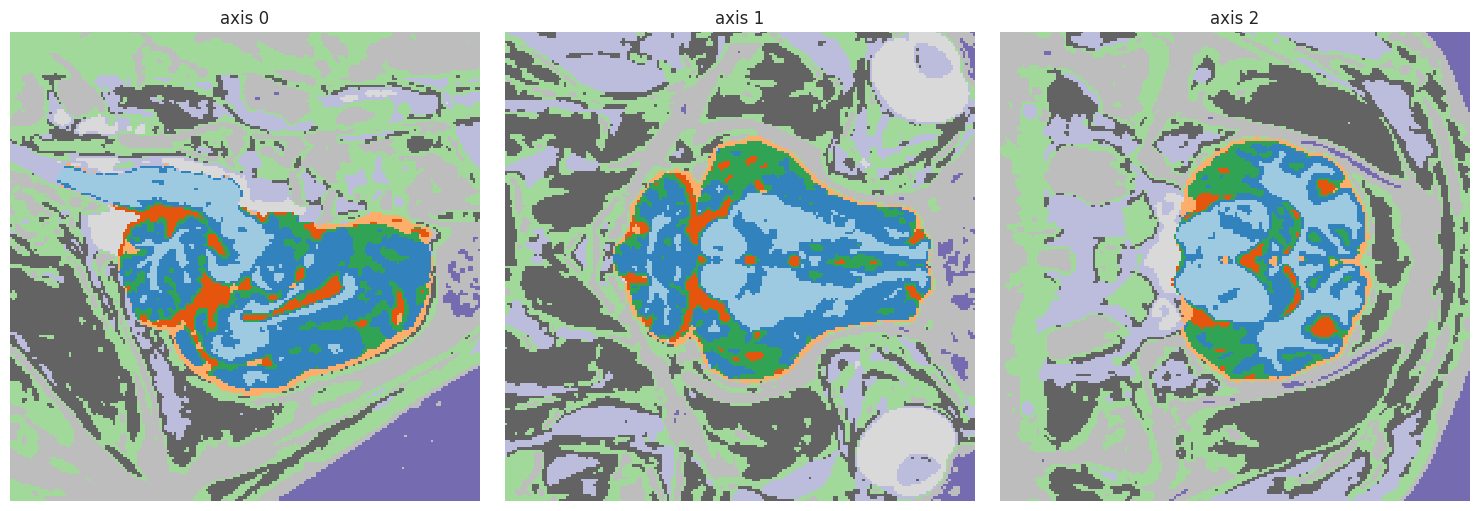

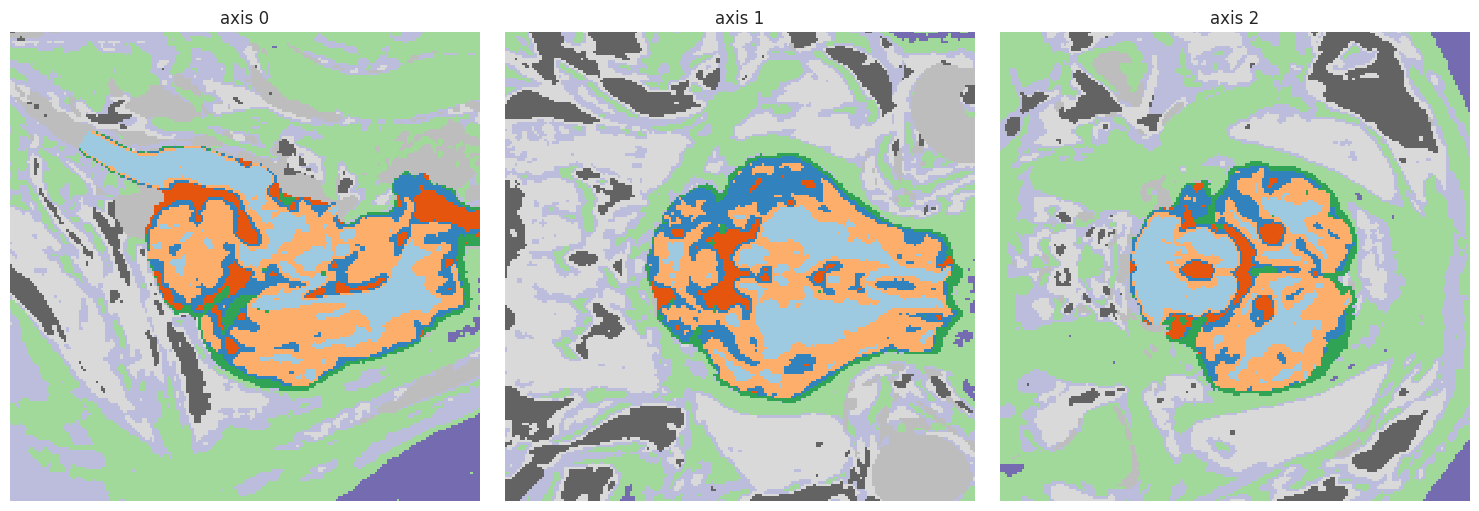

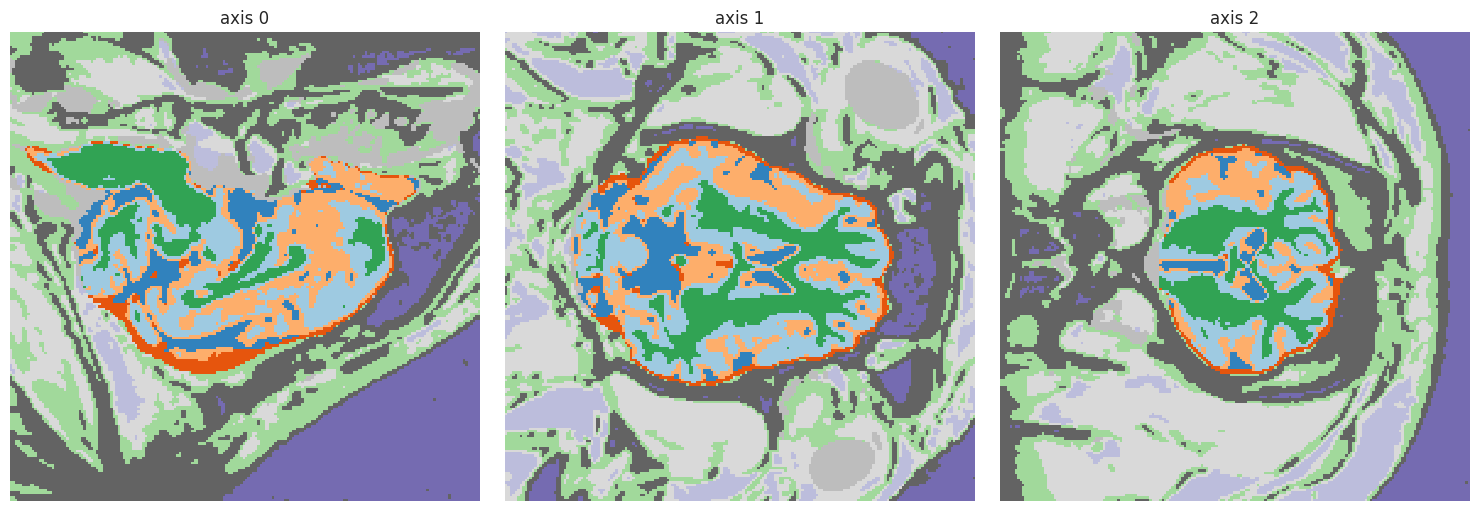

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [132]:
ne.plot.volume3D(predicted_anat_labels[0],cmaps=['tab20c'])
ne.plot.volume3D(predicted_anat_labels[1],cmaps=['tab20c'])
ne.plot.volume3D(predicted_anat_labels[2],cmaps=['tab20c'])

In [133]:
len(predicted_anat_labels)

3

In [1]:
!pip install Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 24.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.17.2 requires networkx>=2.0, which is not installed.
